# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import math

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import dask

import vector
import particle
import hepunits

import comet_ml
import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import SequentialLR, LambdaLR, CosineAnnealingLR

import multiprocessing
import uuid

from memflow.dataset.data import ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.ttH.ttH_dataclasses import ttHHardDataset, ttHRecoDataset
from memflow.callbacks.transfer_flow_callbacks import SamplingCallback, BiasCallback

from memflow.ttH.models.TransferCFM import StandardCFM, OptimalTransportCFM, TargetBridgingCFM, SchrodingerBridgeCFM, VariancePreservingCFM
from models.utils import plot_trajectories_2d, compare_distributions
from models.callbacks import CFMSamplingCallback

vector.register_awkward()

num_workers = min(16, multiprocessing.cpu_count())  # Use up to 16 CPU cores
print(f'Number of CPU workers for dataloading: {num_workers}')
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # Change "<n>" to the index of the GPU you want to use on node

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')
if accelerator =='cuda':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
2025-02-12 13:55:37.056163: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 13:55:37.056237: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 13:55:37.056246: E tensorflow/c

Number of CPU workers for dataloading: 16
Running on GPU : True
Accelerator : cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 

# Data

In [2]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        #'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    # N = int(1e5),
)

print (data_hard)

Data object
Loaded branches:
   ... file: 1903554
   ... sample: 1903554
   ... tree: 1903554
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi

# Hard dataset

In [3]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)

obj = hard_dataset.objects['neutrinos']

# Check its type
print("Type of neutrinos object:", type(obj))

# If it’s a tuple, print its length
if isinstance(obj, tuple):
    print("Length of tuple:", len(obj))
    for i, element in enumerate(obj):
        print(f"Element {i} has type {type(element)} and shape/length:", end=" ")
        # If element is a torch.Tensor or numpy array:
        if hasattr(element, 'shape'):
            print(element.shape)
        # If it's a list of fields:
        else:
            print(element)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard


Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Type of neutrinos object: <class 'tuple'>
Length of tuple: 3
Element 0 has type <class 'torch.Tensor'> and shape/length: torch.Size([756642, 4, 5])
Element 1 has type <class 'torch.Tensor'> and shape/length: torch.Size([756642, 4])
Element 2 has type <class 'torch.Tensor'> and shape/length: torch.Size([756642, 4])


Before preprocessing


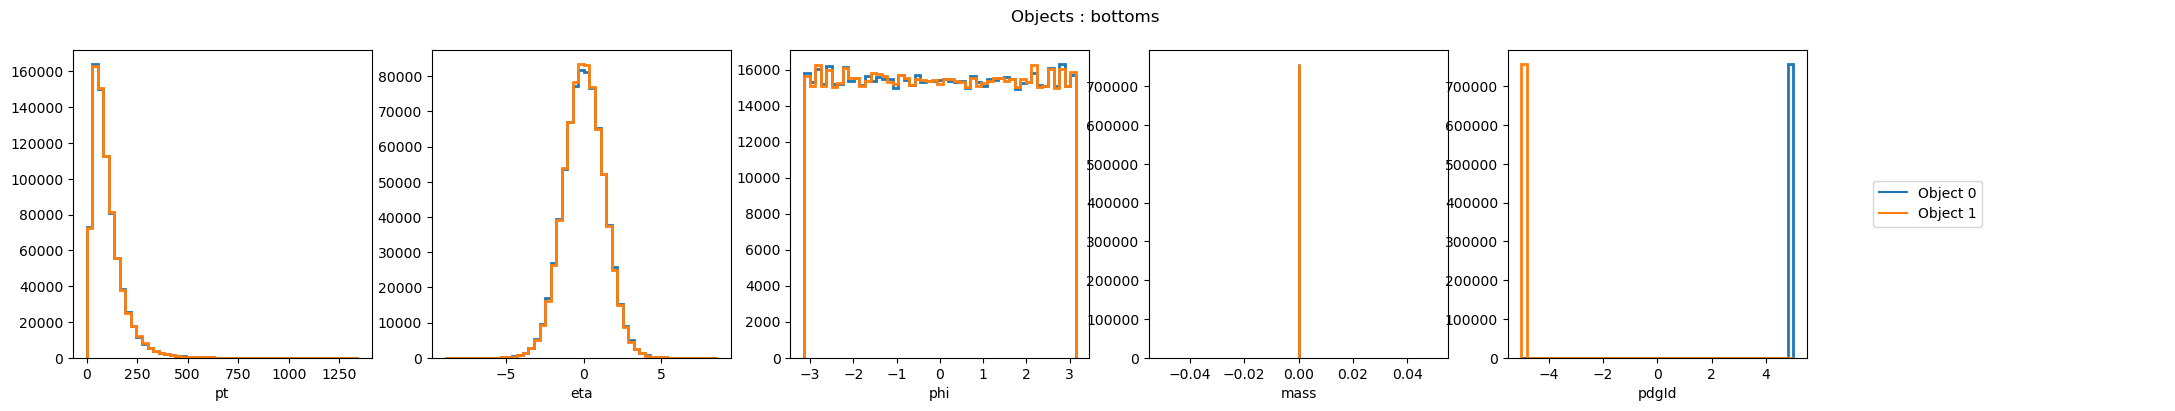

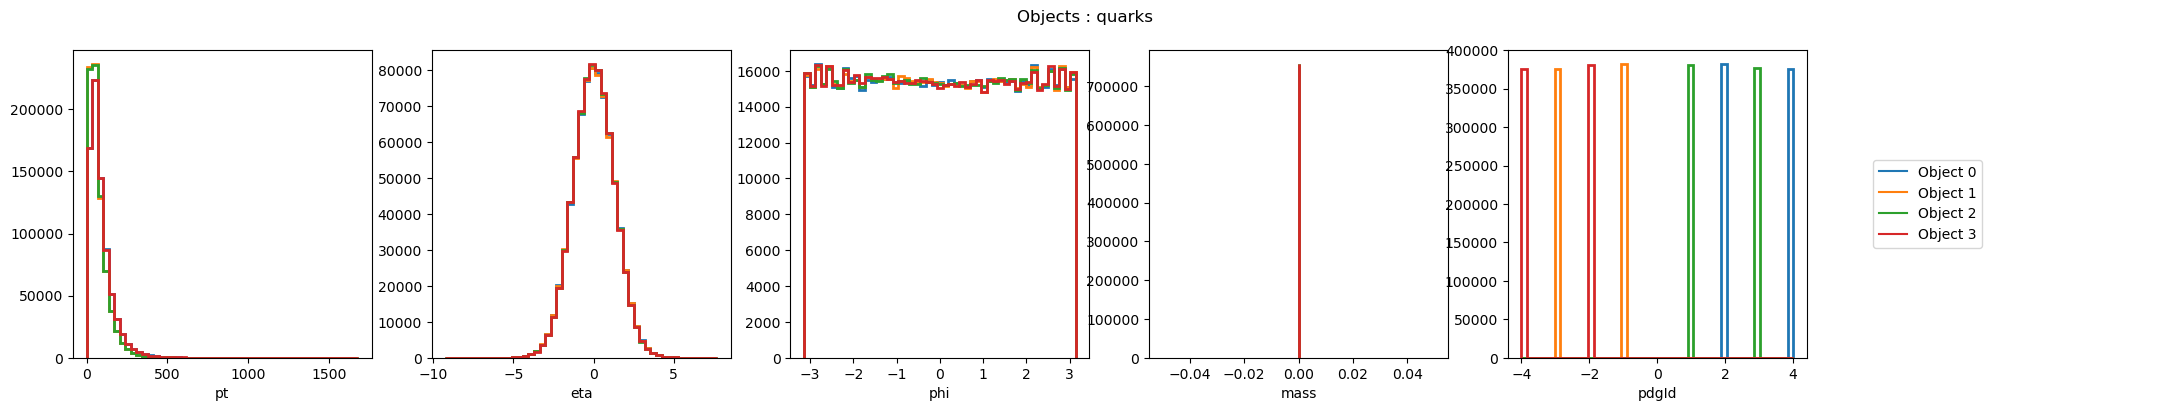

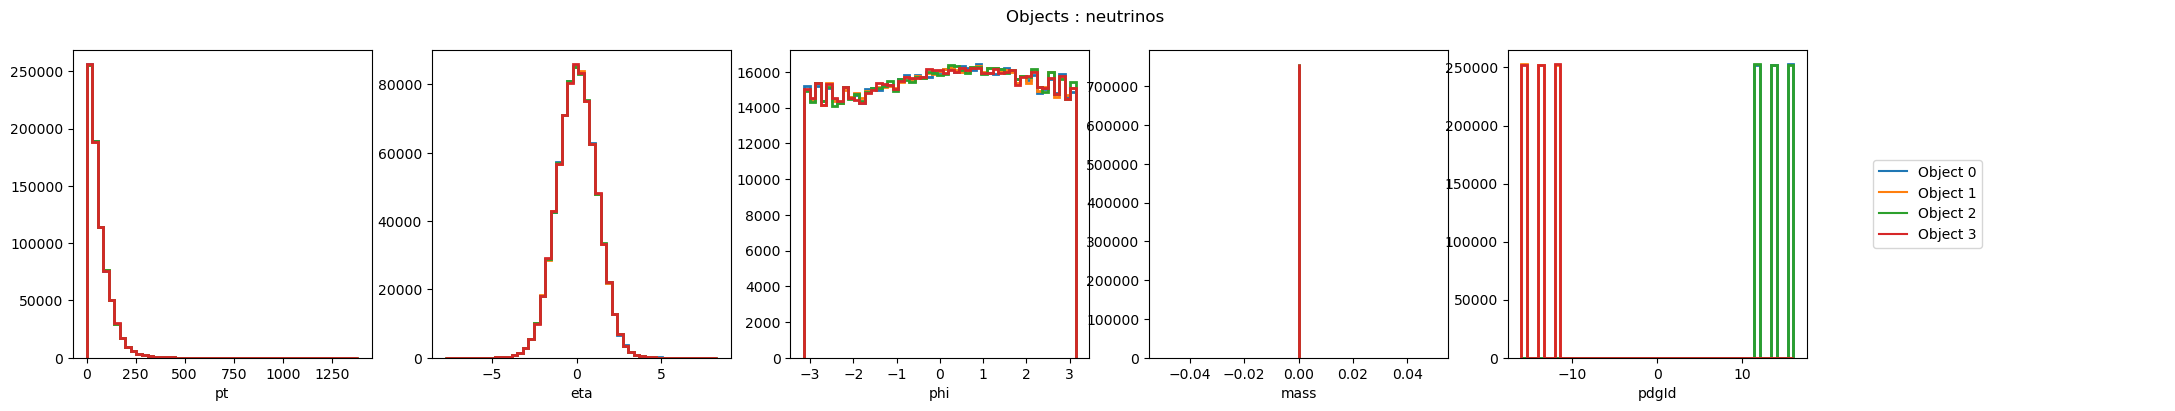

After preprocessing


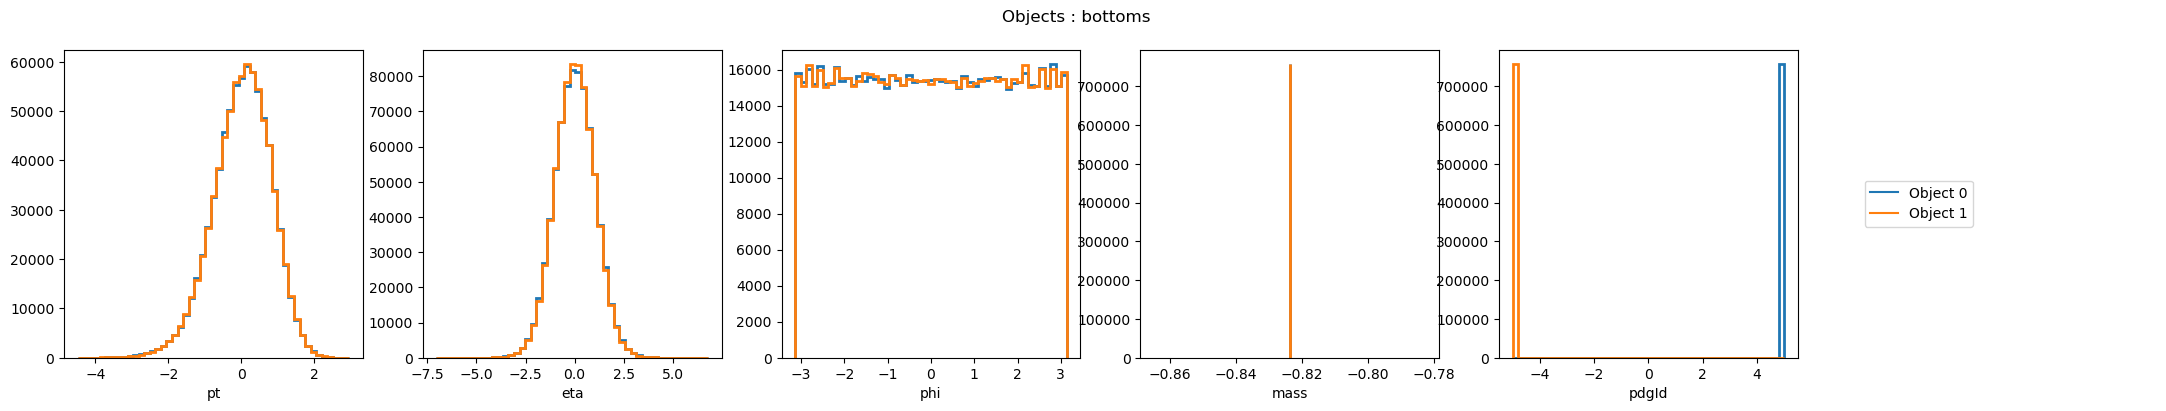

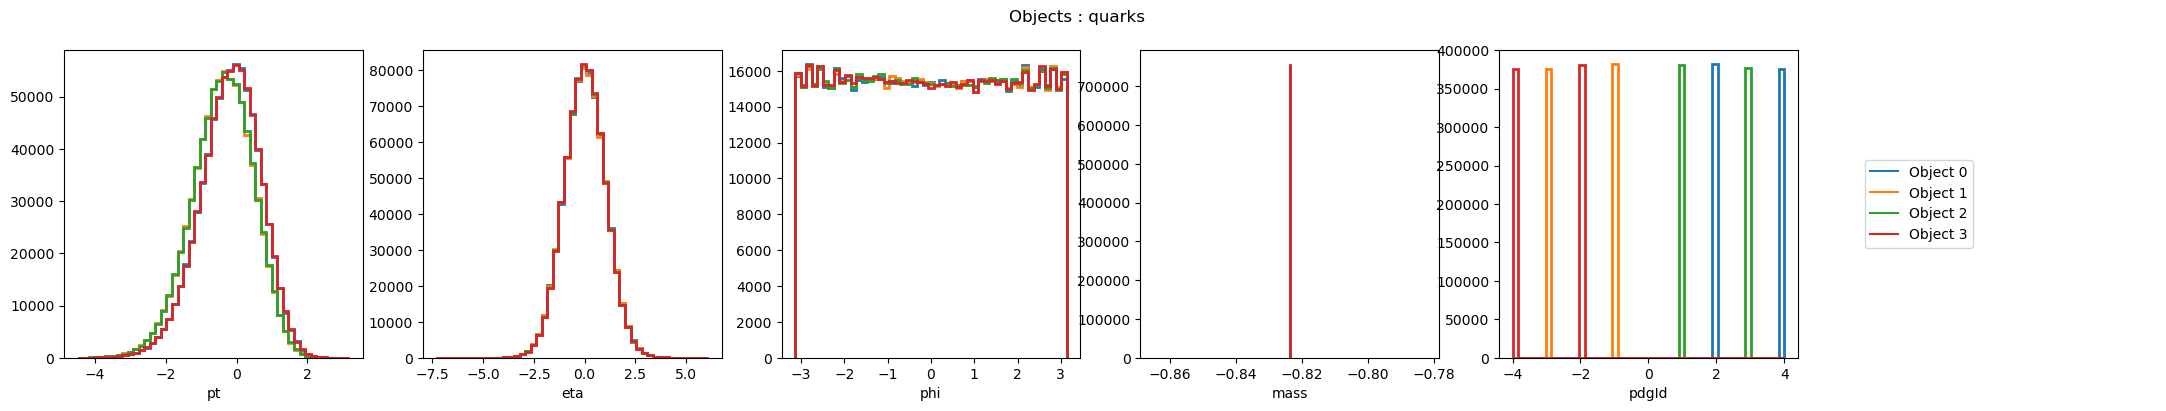

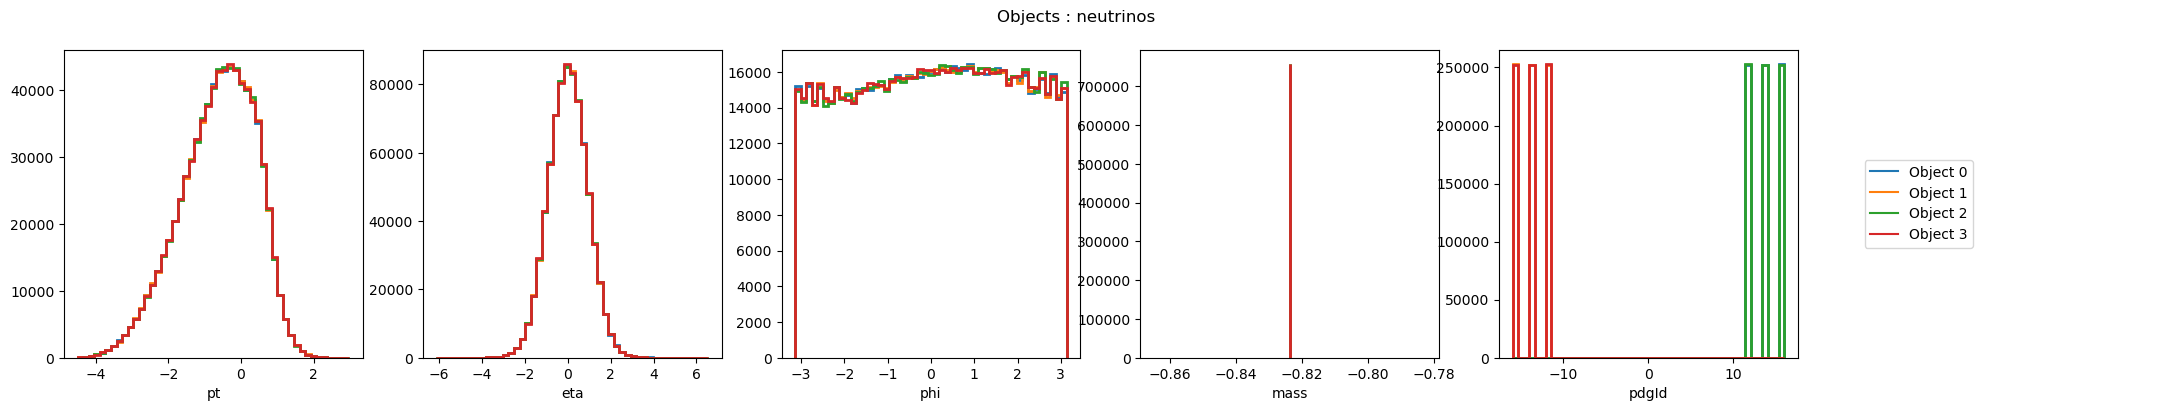

In [4]:
print ('Before preprocessing')
hard_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
hard_dataset.plot(selection=True,raw=False)

In [5]:
# This is not strictly necessary, but just to make sure loading works as expected
# We will use later a combined dataset (hard+reco) below
hard_loader = DataLoader(
    hard_dataset,
    batch_size = 32,
    num_workers = num_workers, # Parallel loading
    pin_memory = True, # Faster transfer to GPU
)
batch = next(iter(hard_loader))

for obj,mask,sel in zip(batch['data'],batch['mask'],hard_loader.dataset.selection):
    print (sel,obj.shape,mask.shape)

bottoms torch.Size([32, 2, 5]) torch.Size([32, 2])
quarks torch.Size([32, 4, 5]) torch.Size([32, 4])
neutrinos torch.Size([32, 4, 5]) torch.Size([32, 4])


# Reco dataset

In [6]:
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
    #N = data_hard.N,
)

print(data_reco)

Data object
Loaded branches:
   ... file: 231528
   ... sample: 231528
   ... tree: 231528
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... InputMet_phi
   ... InputMet_pt
   ... cleanedJet_btagDeepFlavB
   ... cleanedJet_eta
   ... cleanedJet_mass
   ... cleanedJet_phi
   ... cleanedJet_pt
   ... event
   ... ncleanedBJet
   ... ncleanedJet
   ... region
   ... weight_nominal
   ... xs_weight


Have a look at athe minimum values for Jet and MET pT in the raw dataset. This can give an indication as to what the cutoff in the SR is and hence what to set the `'pt':lowercutshift()` to in the pre-processing

In [7]:
# Extract MET pt from raw dataset
raw_met_pt = data_reco['InputMet_pt']
# Print min and max MET pt
print("Raw Minimum MET pt:", ak.min(raw_met_pt))
print("Raw Maximum MET pt:", ak.max(raw_met_pt))

# Extract Jet pt from raw dataset
raw_jet_pt = data_reco['cleanedJet_pt']
# Print min and max MET pt
print("Raw Minimum MET pt:", ak.min(raw_jet_pt))
print("Raw Maximum MET pt:", ak.max(raw_jet_pt))

Raw Minimum MET pt: 200.125
Raw Maximum MET pt: 1787.0
Raw Minimum MET pt: 30.00006103515625
Raw Maximum MET pt: 2340.426025390625


In [ ]:
reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Before cut 231528
After cut 114647
Saving objects to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Reco dataset with 114647 events
Containing the following tensors
jets  : data ([114647, 6, 5]), mask ([114647, 6])
        Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 62.85%]
        Mask attn     : [True, True, True, True, True, True]
        Weights       : 114647.00, 114647.00, 114647.00, 114647.00, 114647.00, 114647.00
        Features      : ['pt', 'eta', 'phi', 'mass', 'btag']
        Selected for batches : True
met   : data ([114647, 1, 4]), mask ([114647, 1])
        Mask exist    : [100.00%]
        Mask attn     : [True]
        Weights       : 114647

Before preprocessing


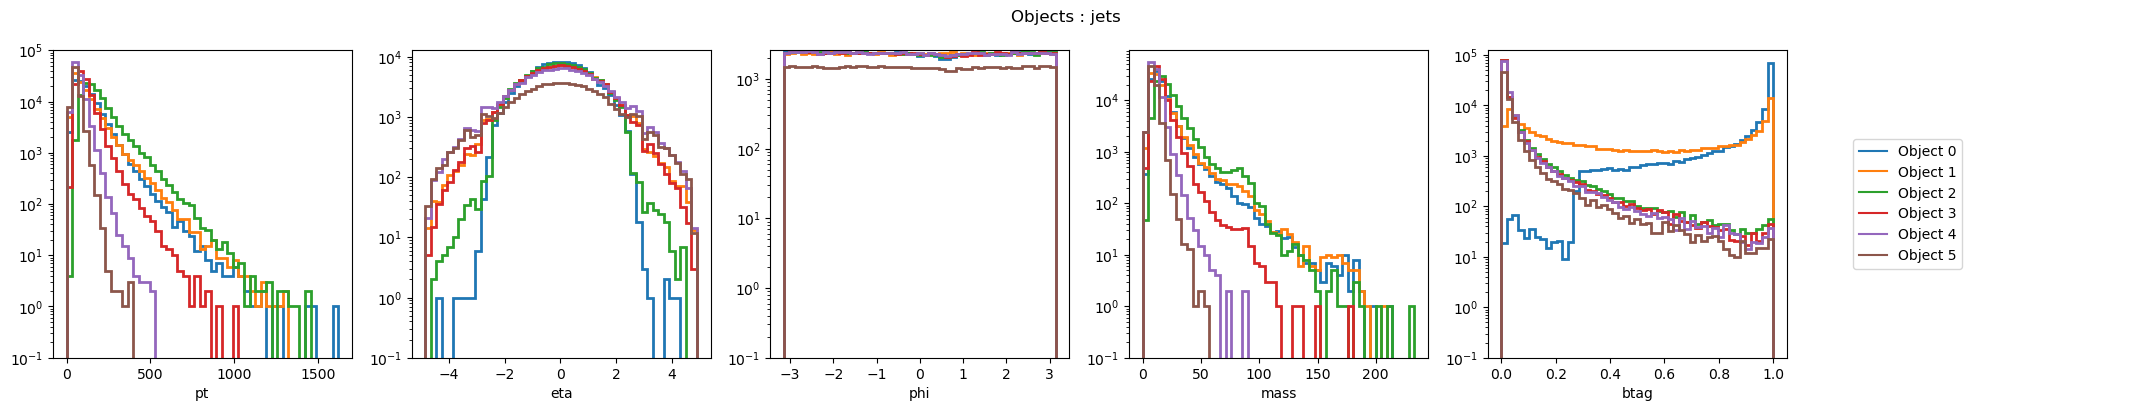

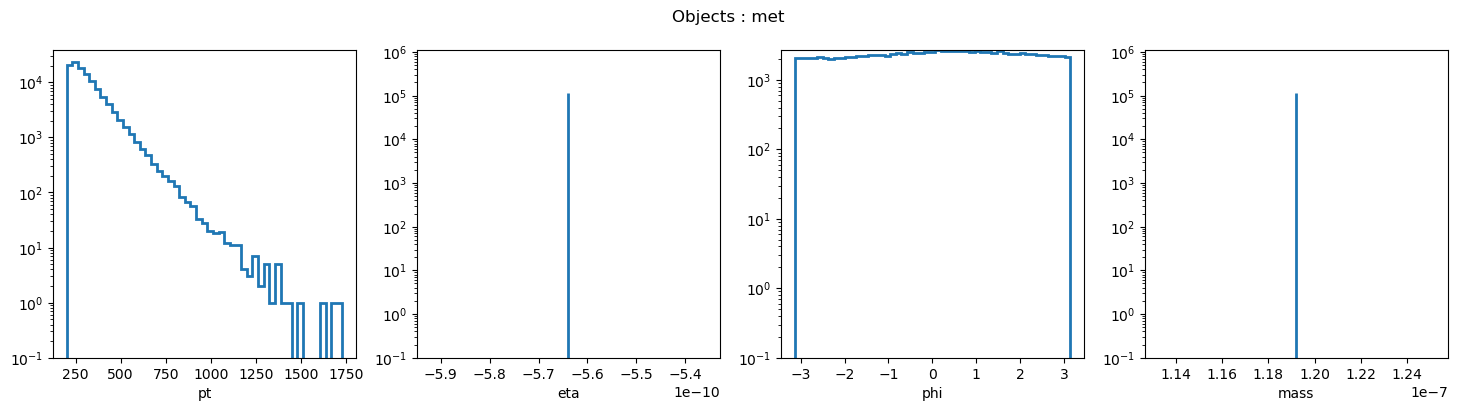

After preprocessing


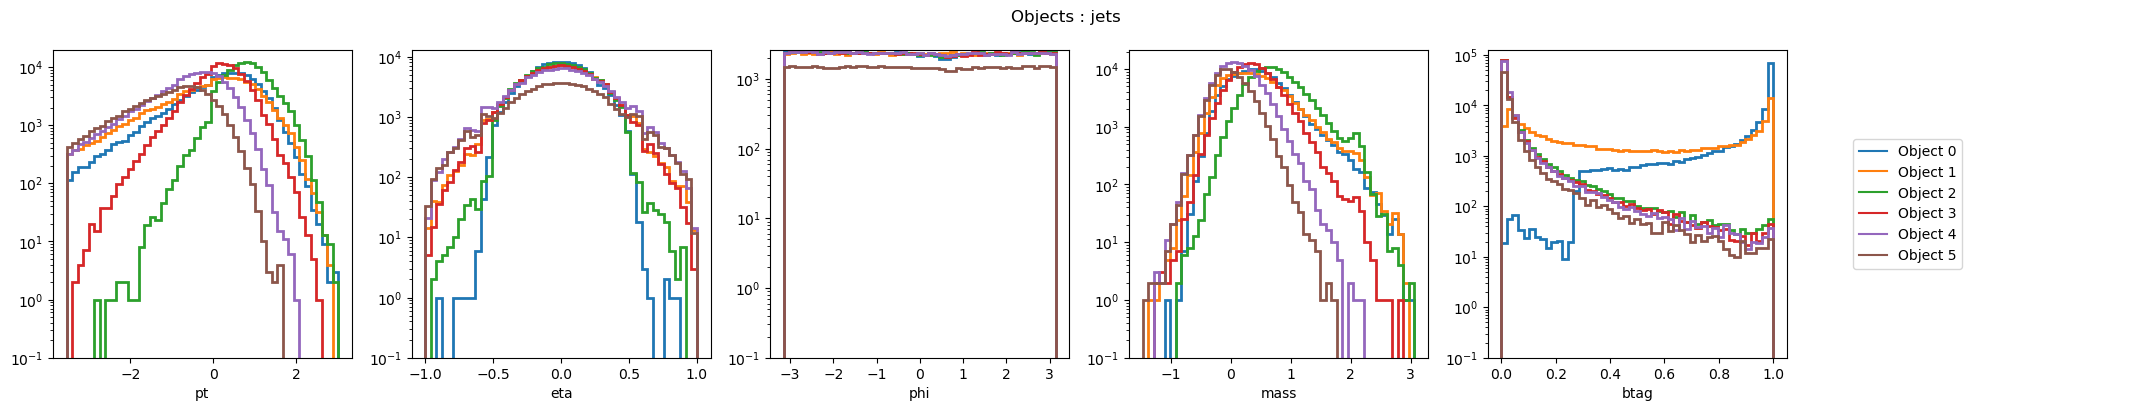

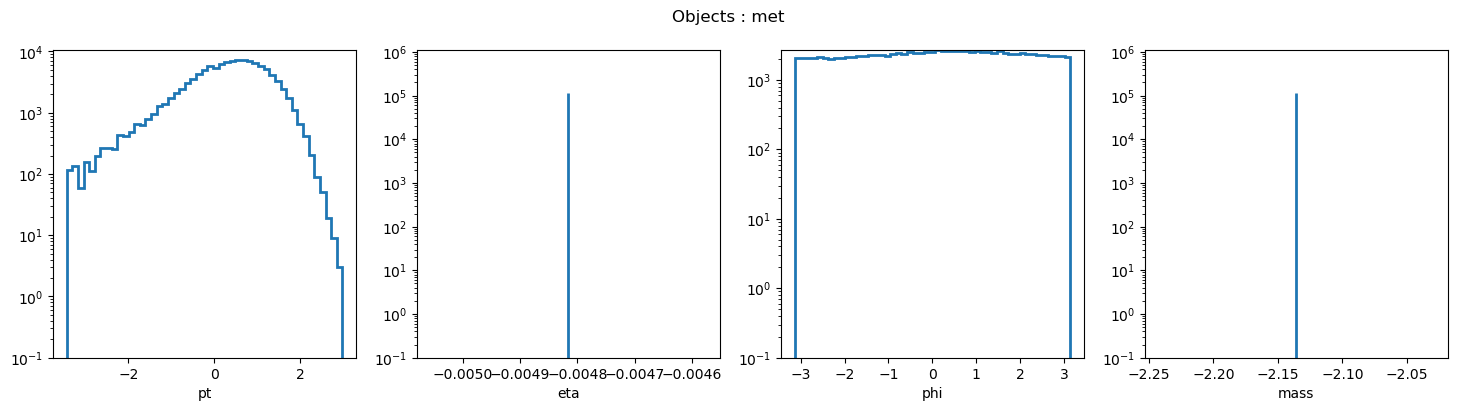

In [9]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True)

In [10]:
# Also not needed, just checking 
reco_loader = DataLoader(
    reco_dataset,
    batch_size = 32,
    num_workers = num_workers,
    pin_memory = True,
)
batch = next(iter(reco_loader))

for obj,mask,sel in zip(batch['data'],batch['mask'],reco_loader.dataset.selection):
    print (sel,obj.shape,mask.shape)

jets torch.Size([32, 6, 5]) torch.Size([32, 6])
met torch.Size([32, 1, 4]) torch.Size([32, 1])


# Combined dataset

In [11]:
print(f'Intersection Branch: {reco_dataset.intersection_branch}')
print (f'Hard Datset keys: {hard_dataset.metadata.keys()}')
print (f'Reco Datset keys: {reco_dataset.metadata.keys()}')

combined_dataset = CombinedDataset(
    hard_dataset=hard_dataset,
    reco_dataset=reco_dataset,
)
print(combined_dataset)

Intersection Branch: event
Hard Datset keys: dict_keys(['file', 'tree', 'sample', 'intersection'])
Reco Datset keys: dict_keys(['file', 'tree', 'sample', 'intersection'])
Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet <-> /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet
For entry 0 : from 756642 events, 91819 selected
For entry 1 : from 114647 events, 91819 selected
Combined dataset (extracting 91819 events of the following) :
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
bottoms    : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True

In [12]:
combined_loader = DataLoader(
    combined_dataset,
    batch_size = 256,
)
batch = next(iter(combined_loader))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],combined_loader.dataset.reco_dataset.selection):
    print (sel,obj.shape,mask.shape)

print ('Hard')
for obj,mask,sel in zip(batch['hard']['data'],batch['hard']['mask'],combined_loader.dataset.hard_dataset.selection):
    print (sel,obj.shape,mask.shape)

Reco
jets torch.Size([256, 6, 5]) torch.Size([256, 6])
met torch.Size([256, 1, 4]) torch.Size([256, 1])
Hard
bottoms torch.Size([256, 2, 5]) torch.Size([256, 2])
quarks torch.Size([256, 4, 5]) torch.Size([256, 4])
neutrinos torch.Size([256, 4, 5]) torch.Size([256, 4])


In [13]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.8
indices = torch.arange(len(combined_dataset))
sep = int(train_frac*len(combined_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

combined_dataset_train = torch.utils.data.Subset(combined_dataset,train_indices)
combined_dataset_valid = torch.utils.data.Subset(combined_dataset,valid_indices)
print (f'Dataset : training {len(combined_dataset_train)} / validation {len(combined_dataset_valid)}')

batch_size = 1024

combined_loader_train = DataLoader(
    combined_dataset_train,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True,
)
combined_loader_valid = DataLoader(
    combined_dataset_valid,
    batch_size = 10000,
    shuffle = False,
    num_workers = num_workers,
    pin_memory = True,
)
print (f'Batching {len(combined_loader_train)} / Validation {len(combined_loader_valid)}')

Dataset : training 73455 / validation 18364
Batching 72 / Validation 2


# TransferCFM

In [14]:
print(combined_dataset.hard_dataset.input_features) # Determine the available features that you can select in ` flow_input_features`
# Note the length of this (2 elements) must match the length of  `flow_input_features`
# But you dont have to select all the features in each element
print(combined_dataset.reco_dataset.input_features)

(('pt', 'eta', 'phi', 'mass', 'pdgId'), ('pt', 'eta', 'phi', 'mass', 'pdgId'), ('pt', 'eta', 'phi', 'mass', 'pdgId'))
(('pt', 'eta', 'phi', 'mass', 'btag'), ('pt', 'eta', 'phi', 'mass'))


In [15]:
for i, (obj, mask) in enumerate(zip(batch['reco']['data'], batch['reco']['mask'])):
    print(f"Reco Object {i}: Shape = {obj.shape}, Mask Shape = {mask.shape}")
for i, (obj, mask) in enumerate(zip(batch['hard']['data'], batch['hard']['mask'])):
    print(f"Hard Object {i}: Shape = {obj.shape}, Mask Shape = {mask.shape}")


Reco Object 0: Shape = torch.Size([256, 6, 5]), Mask Shape = torch.Size([256, 6])
Reco Object 1: Shape = torch.Size([256, 1, 4]), Mask Shape = torch.Size([256, 1])
Hard Object 0: Shape = torch.Size([256, 2, 5]), Mask Shape = torch.Size([256, 2])
Hard Object 1: Shape = torch.Size([256, 4, 5]), Mask Shape = torch.Size([256, 4])
Hard Object 2: Shape = torch.Size([256, 4, 5]), Mask Shape = torch.Size([256, 4])


In [16]:
print(combined_dataset.hard_dataset.input_features)
print(combined_dataset.reco_dataset.input_features)

(('pt', 'eta', 'phi', 'mass', 'pdgId'), ('pt', 'eta', 'phi', 'mass', 'pdgId'), ('pt', 'eta', 'phi', 'mass', 'pdgId'))
(('pt', 'eta', 'phi', 'mass', 'btag'), ('pt', 'eta', 'phi', 'mass'))


In [18]:
# Instantiate CFM model
model = StandardCFM(
    embed_dims=[32, 64],
    embed_act=nn.GELU,
    dropout=0.0,

    n_hard_particles_per_type=combined_dataset.hard_dataset.number_particles_per_type,
    hard_particle_type_names=combined_dataset.hard_dataset.selection,
    hard_input_features_per_type=combined_dataset.hard_dataset.input_features, # These are all the features available, speciefied in dataclass

    n_reco_particles_per_type=combined_dataset.reco_dataset.number_particles_per_type,
    reco_particle_type_names= combined_dataset.reco_dataset.selection,
    reco_input_features_per_type=combined_dataset.reco_dataset.input_features,

    # Only pick a subset in bridging:
    flow_input_features = [
        ["pt", "eta", "phi"],  # Features for reco type 0 (e.g., jets)
        ["pt", "phi"],         # Features for reco type 1 (e.g., MET)
        # Add more reco types as needed
    ],

    hard_mask_attn=None,
    reco_mask_attn=reco_dataset.attention_mask,
    transformer_args={
        "nhead": 8,
        "num_encoder_layers": 6, # was 8, new 6
        "num_decoder_layers": 8,
        "dim_feedforward": 256, # was 128, new 256
        "activation": "relu", # was gelu, new relu
    },
    cfm_args={
        "dim_feedforward": 512, # was 128, new 512
        "num_layers": 8, # was 2, new 8
        "activation": nn.SiLU,
    },
    sigma=0.1,
    # # ot_reg=0.1, # For OT CFMs
    # ot_method='exact', # For OT & SchrodingBridge CFMs
    # # normalize_cost=True, # For sinkhorn ot_method
)


# Quick test on one batch
batch = next(iter(combined_loader_train))
for i, (obj, mask) in enumerate(zip(batch["hard"]["data"], batch["hard"]["mask"])):
    print(f"hard_data[{i}] shape = {obj.shape}, mask shape = {mask.shape}")
for i, (obj, mask) in enumerate(zip(batch["reco"]["data"], batch["reco"]["mask"])):
    print(f"reco_data[{i}] shape = {obj.shape}, mask shape = {mask.shape}")
loss = model(batch)
print("Initial CFM loss:", loss.item())

print(model)

No hard attention mask provided; will use existence mask only.
hard_data[0] shape = torch.Size([1024, 2, 5]), mask shape = torch.Size([1024, 2])
hard_data[1] shape = torch.Size([1024, 4, 5]), mask shape = torch.Size([1024, 4])
hard_data[2] shape = torch.Size([1024, 4, 5]), mask shape = torch.Size([1024, 4])
reco_data[0] shape = torch.Size([1024, 6, 5]), mask shape = torch.Size([1024, 6])
reco_data[1] shape = torch.Size([1024, 1, 4]), mask shape = torch.Size([1024, 1])
Initial CFM loss: 2.308738946914673
StandardCFM(
  (hard_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )


In [19]:
print(type(batch['hard']['data']), len(batch['hard']['data'])) # len = 2 is for 2 particles
print(type(batch['reco']['data']), len(batch['reco']['data']))

<class 'list'> 3
<class 'list'> 2


In [20]:
# Callbacks to make plots within comet
bias = BiasCallback(
    dataset = combined_dataset_valid,               # dataset on which to evaluate bias
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline to draw raw variables
    N_sample = 100,                                 # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    store_trajectories = False,                     # To save trajectories plots
    frequency = 33,                                 # plotting frequency (epochs)
    raw = True,
    bins = 101,                                      # 1D/2D plot number of bins
    points = 20,                                    # Number of points for the quantile
    log_scale = True,                               # log
    batch_size = 1000,                              # Batch size to evaluate the dataset (internally makes a loaded)
    N_batch = 1,                                   # Stop after N batches (makes it faster)
    suffix = 'ttH',                                 # name for plots
    label_names = {                                 # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)

sampling = SamplingCallback(
    dataset = combined_dataset_valid,           # dataset to check sampling
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline
    idx_to_monitor = [5,6,7],               # idx of events in dataset to make plots with
    N_sample = 1000,                         # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    store_trajectories = False,                     # To save trajectories plots
    frequency = 33,                             # plotting frequency (epochs)
    bins = 51,                                  # 1D/2D plot number of bins
    log_scale = True,                           # log
    label_names = {                             # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)

In [21]:
epochs = 5
steps_per_epoch_train = math.ceil(len(combined_dataset_train)/combined_loader_train.batch_size)

# 4) Optimizer + scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-5) # was lr=1e-3
model.set_optimizer(optimizer)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer=optimizer,
#     mode='min',
#     factor=0.1,
#     patience=10,
#     threshold=0.001,
#     threshold_mode='rel',
#     cooldown=0,
#     min_lr=1e-7
# )

scheduler = CosineAnnealingLR(
    optimizer=optimizer,
    T_max=epochs,  # Num epochs before lr is reduced to min val
    # eta_min=1e-6   # Min value lr can decay to
    )

model.set_scheduler_config({
    'scheduler': scheduler,
    'interval': 'epoch',
    'frequency': 1,
    'monitor': 'val_loss',  # <-- or 'val/loss_tot' if you prefer
    'strict': True,
    'name': 'scheduler',
})

# 5) Logger + Trainer
logger = pl_loggers.CometLogger(
    save_dir='../comet_logs',
    project_name='mem-flow-ttH',
    experiment_name='combined',
    offline=True,
    # experiment_key="4f3d2b1e843d489ea4ebd17ce92d9035", # Overwrite existing experiment
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    sampling,
    bias,
]

trainer = L.Trainer(
    min_epochs=5,
    max_epochs=epochs,
    callbacks=callbacks,
    devices='auto',
    accelerator='auto',
    logger=logger,
    log_every_n_steps=steps_per_epoch_train // 100,
)

# 6) Fit
trainer.fit(
    model=model,
    train_dataloaders=combined_loader_train,
    val_dataloaders=combined_loader_valid,
)

logger.experiment.end()

CometLogger will be initialized in offline mode
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: COMET_API_KEY was set, but is ignored in offline experiment; remember to set when you upload
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

   | Name                | Type               | Params | Mode 
--------------------------------------------------------------------
0  | hard_embeddings     | ModuleList         | 7.0 K  | train
1  | hard_embeddings.0   | Sequential         | 2.3 K  | train
2  | hard_embeddings.1   | Sequential         | 2.3 K  | train
3  | hard_embeddi

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : combined
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [37]                    : (0.3109065294265747, 2.318300485610962)
COMET INFO:     scheduler [5]                : (9.549150281252633e-07, 1e-05)
COMET INFO:     val/velocity_loss_jets_0 [5] : (0.3140263855457306, 0.6417458057403564)
COMET INFO:     val/velocity_loss_jets_1 [5] : (0.3140263855457306, 0.6417458057403564)
COMET INFO:     val/velocity_loss_jets_2 [5] : (0.3140263855457306, 0.6417458057403564)
COMET INFO:     val/velocity_loss_jets

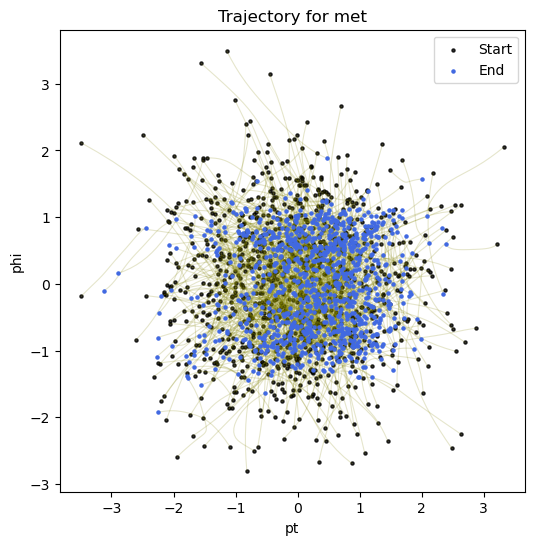

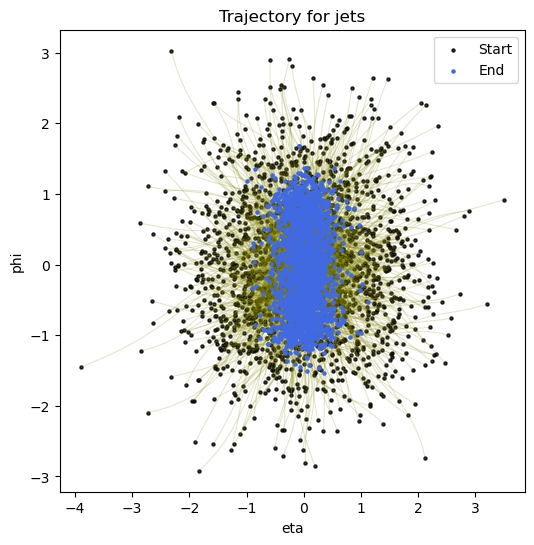

In [22]:
# After training, manually evaluate the model
batch = next(iter(combined_loader_valid))

# Move batch to the model's device manually
batch = CFMSamplingCallback.move_batch_to_device(batch, model.device)

model.eval()
model.to(model.device)

with torch.no_grad():
    model = model.to(model.device)

    # Extract the necessary inputs for sampling
    hard_data = batch["hard"]["data"]
    hard_mask = batch["hard"]["mask"]
    reco_data = batch["reco"]["data"]
    reco_mask = batch["reco"]["mask"]

    final_samples, all_traj = model.sample(
        hard_data,
        hard_mask,
        reco_data,
        reco_mask,
        N_sample=1,
        steps=20,
        store_trajectories=True
    )

# all_traj is the shape [N_sample, steps+1, B, sum_reco, 2], used for 2D trajectory plots
# Feature indexes:
#   Jets: "pt"=0, "eta"=1 "phi"=2
#   MET: "pt"=0, "phi"=1
plot_trajectories_2d(
    all_traj,
    model,
    type_idx=1, # "Jets"=0, "met"=1
    feat_idx_x=0,
    feat_idx_y=1,
    num_events=1000,
)
plot_trajectories_2d(
    all_traj,
    model,
    type_idx=0, # "Jets"=0, "met"=1
    feat_idx_x=1,
    feat_idx_y=2,
    num_events=1000,
)

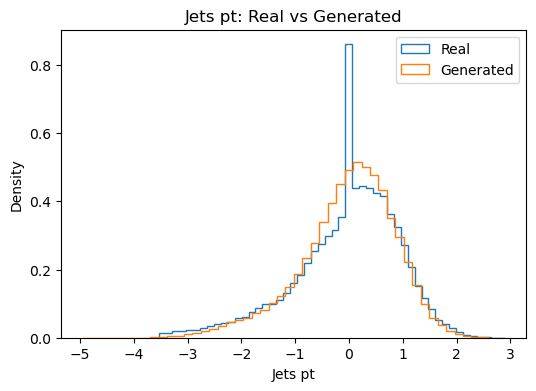

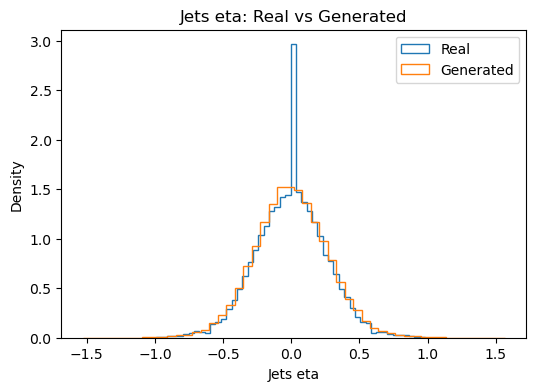

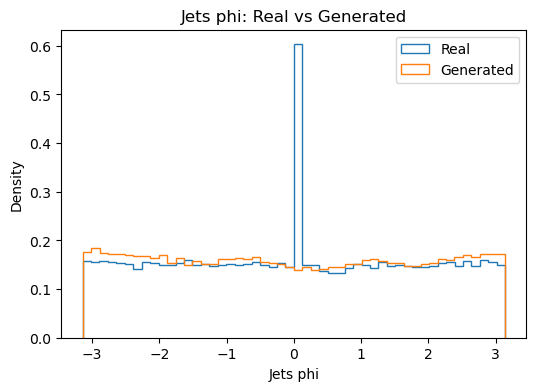

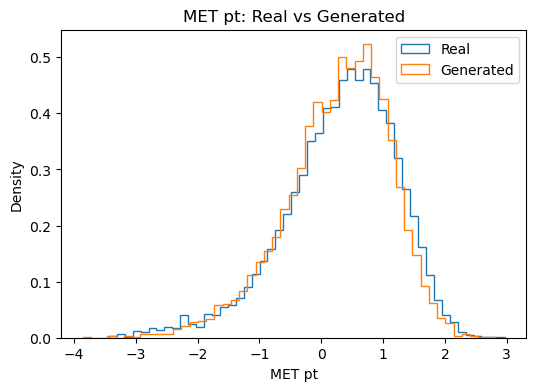

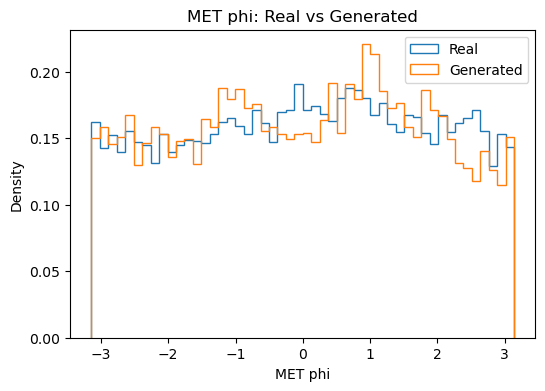

In [23]:
# Extract real and generated data for comparison
# final_samples shape: [particle type, num samples, num events, num particles, num features] e.g.[2, 1, 10000, 6, 3]
real_data = batch["reco"]["data"] # Shape: [particle type, num events, num particles, num features] e.g.[2, 10000, 6, 5]

# Jet Feature indexes:
#   real: "pt"=0, "eta"=1 "phi"=2
#   gen: "pt"=0, "eta"=1 "phi"=2
compare_distributions(real_data[0], final_samples[0], real_feat_idx=0, gen_feat_idx=0, feat_name="Jets pt")
compare_distributions(real_data[0], final_samples[0],  real_feat_idx=1, gen_feat_idx=1, feat_name="Jets eta")
compare_distributions(real_data[0], final_samples[0],  real_feat_idx=2, gen_feat_idx=2, feat_name="Jets phi")

# MET Feature indexes:
#   real: "pt"=0, "phi"=2
#   gen: "pt"=0, "phi"=1
compare_distributions(real_data[1], final_samples[1], real_feat_idx=0, gen_feat_idx=0, feat_name="MET pt")
compare_distributions(real_data[1], final_samples[1], real_feat_idx=2, gen_feat_idx=1, feat_name="MET phi")

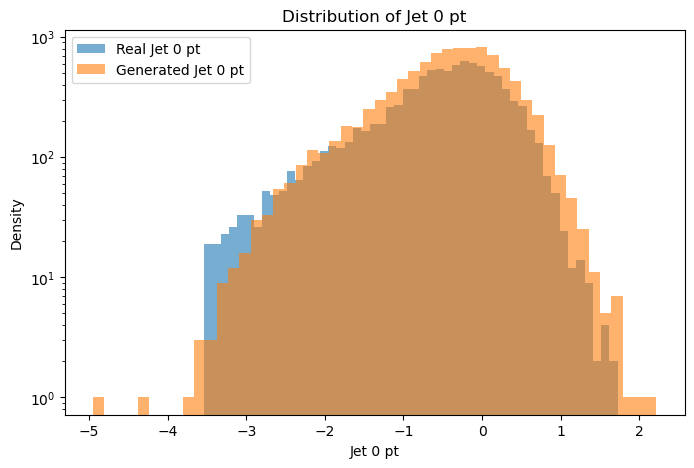

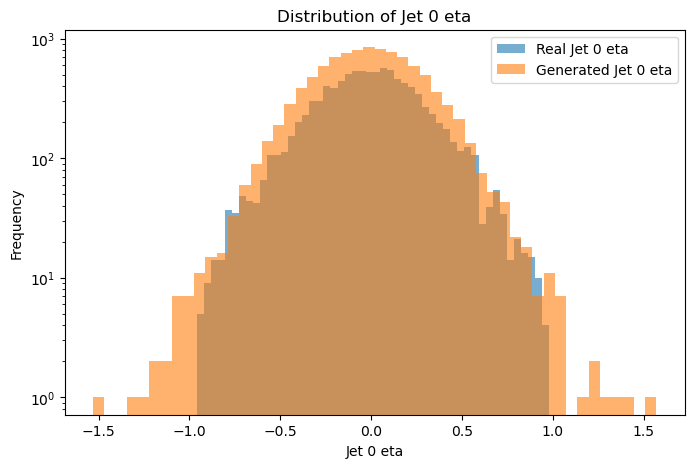

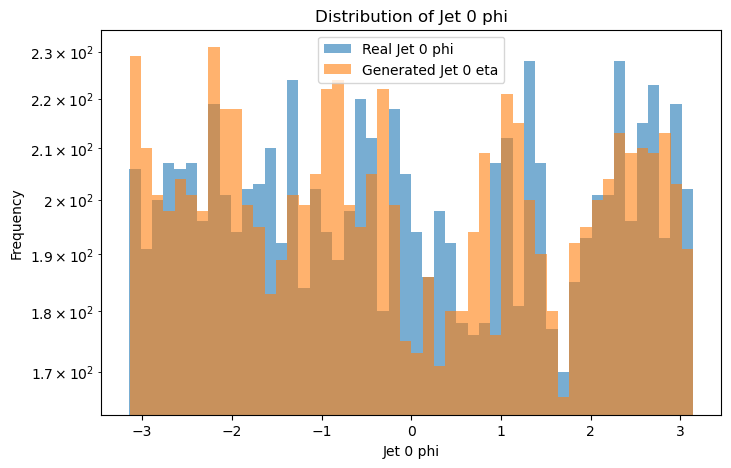

In [24]:
real_jet_0 = real_data[0][:, 4, :]  # Shape: [num_events, num_features]
gen_jet_0 = final_samples[0][:, :, 4, :]  # Shape: [num_samples, num_events, num_features]
real_jet_0_pt = real_jet_0[:, 0]  # Shape: [num_events]
gen_jet_0_pt = gen_jet_0[:, :, 0].flatten()  # Shape: [num_samples * num_events]
real_jet_0_eta = real_jet_0[:, 1]
gen_jet_0_eta = gen_jet_0[:, :, 1].flatten()
real_jet_0_phi = real_jet_0[:, 2]
gen_jet_0_phi = gen_jet_0[:, :, 2].flatten()

plt.figure(figsize=(8, 5))
plt.hist(real_jet_0_pt, bins=50, alpha=0.6, label="Real Jet 0 pt", log=True)
plt.hist(gen_jet_0_pt, bins=50, alpha=0.6, label="Generated Jet 0 pt", log=True)
plt.xlabel("Jet 0 pt")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Jet 0 pt")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(real_jet_0_eta, bins=50, alpha=0.6, label="Real Jet 0 eta", log=True)
plt.hist(gen_jet_0_eta, bins=50, alpha=0.6, label="Generated Jet 0 eta", log=True)
plt.xlabel("Jet 0 eta")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Jet 0 eta")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(real_jet_0_phi, bins=50, alpha=0.6, label="Real Jet 0 phi", log=True)
plt.hist(gen_jet_0_phi, bins=50, alpha=0.6, label="Generated Jet 0 eta", log=True)
plt.xlabel("Jet 0 phi")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Jet 0 phi")
plt.show()


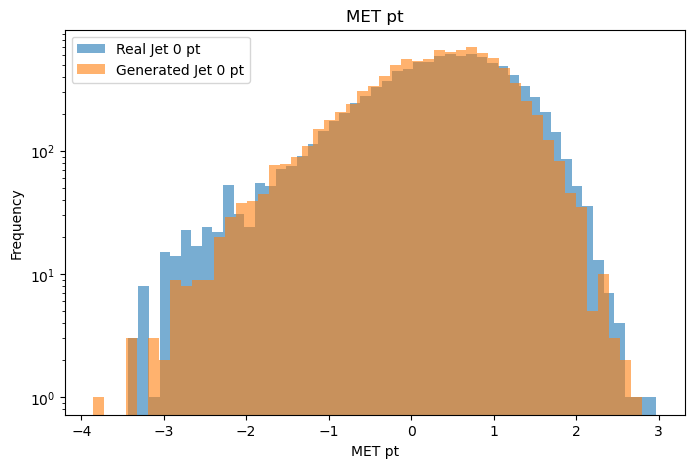

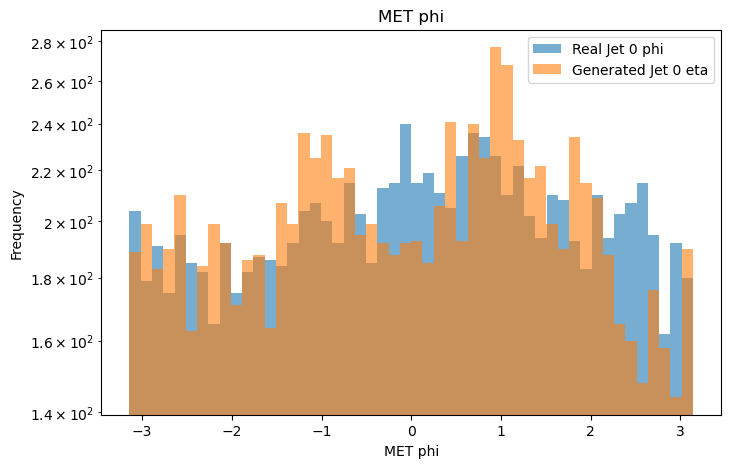

In [25]:
real_jet_0 = real_data[1][:, 0, :]  # Shape: [num_events, num_features]
gen_jet_0 = final_samples[1][:, :, 0, :]  # Shape: [num_samples, num_events, num_features]
real_jet_0_pt = real_jet_0[:, 0]  # Shape: [num_events]
gen_jet_0_pt = gen_jet_0[:, :, 0].flatten()  # Shape: [num_samples * num_events]
real_jet_0_phi = real_jet_0[:, 2]
gen_jet_0_phi = gen_jet_0[:, :, 1].flatten()

plt.figure(figsize=(8, 5))
plt.hist(real_jet_0_pt, bins=50, alpha=0.6, label="Real Jet 0 pt", log=True)
plt.hist(gen_jet_0_pt, bins=50, alpha=0.6, label="Generated Jet 0 pt", log=True)
plt.xlabel("MET pt")
plt.ylabel("Frequency")
plt.legend()
plt.title("MET pt")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(real_jet_0_phi, bins=50, alpha=0.6, label="Real Jet 0 phi", log=True)
plt.hist(gen_jet_0_phi, bins=50, alpha=0.6, label="Generated Jet 0 eta", log=True)
plt.xlabel("MET phi")
plt.ylabel("Frequency")
plt.legend()
plt.title("MET phi")
plt.show()


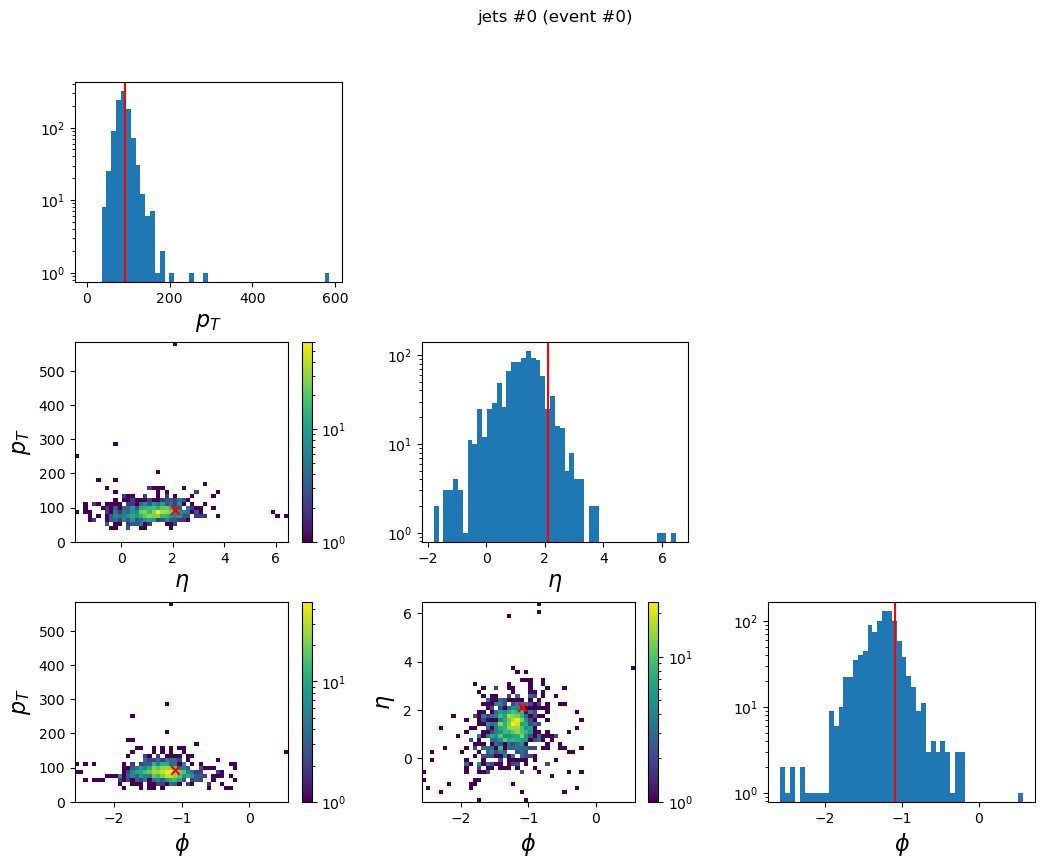

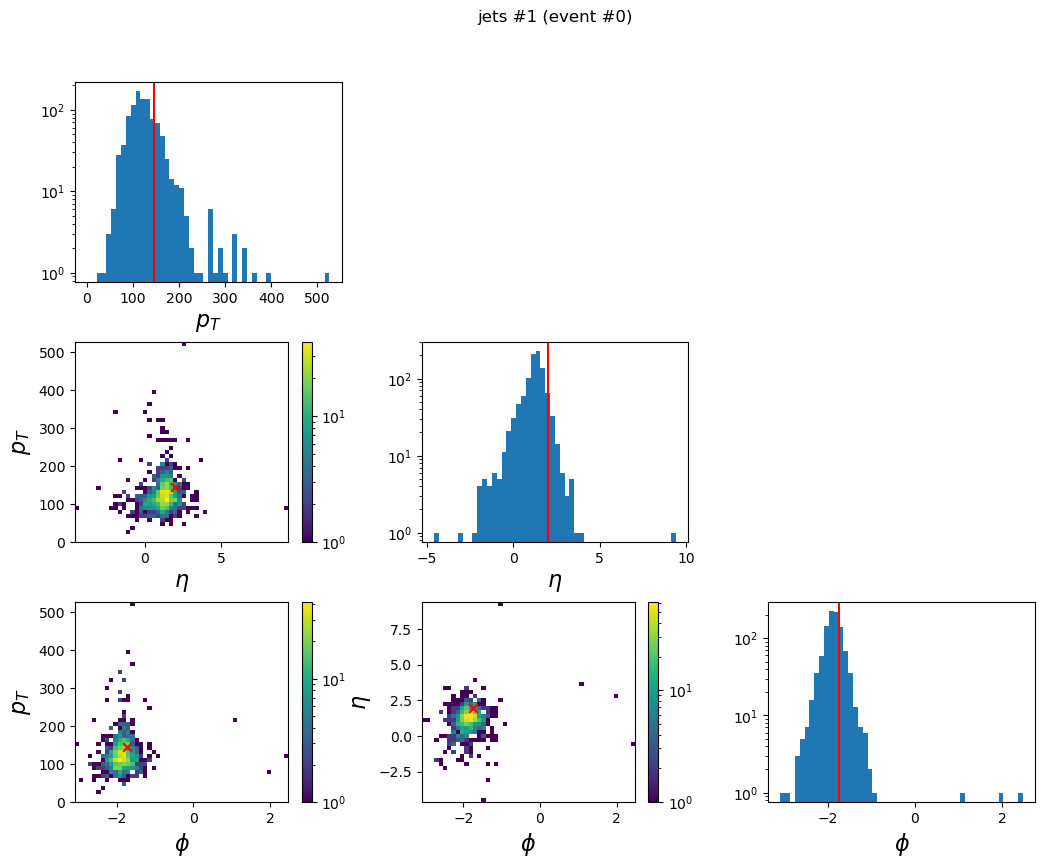

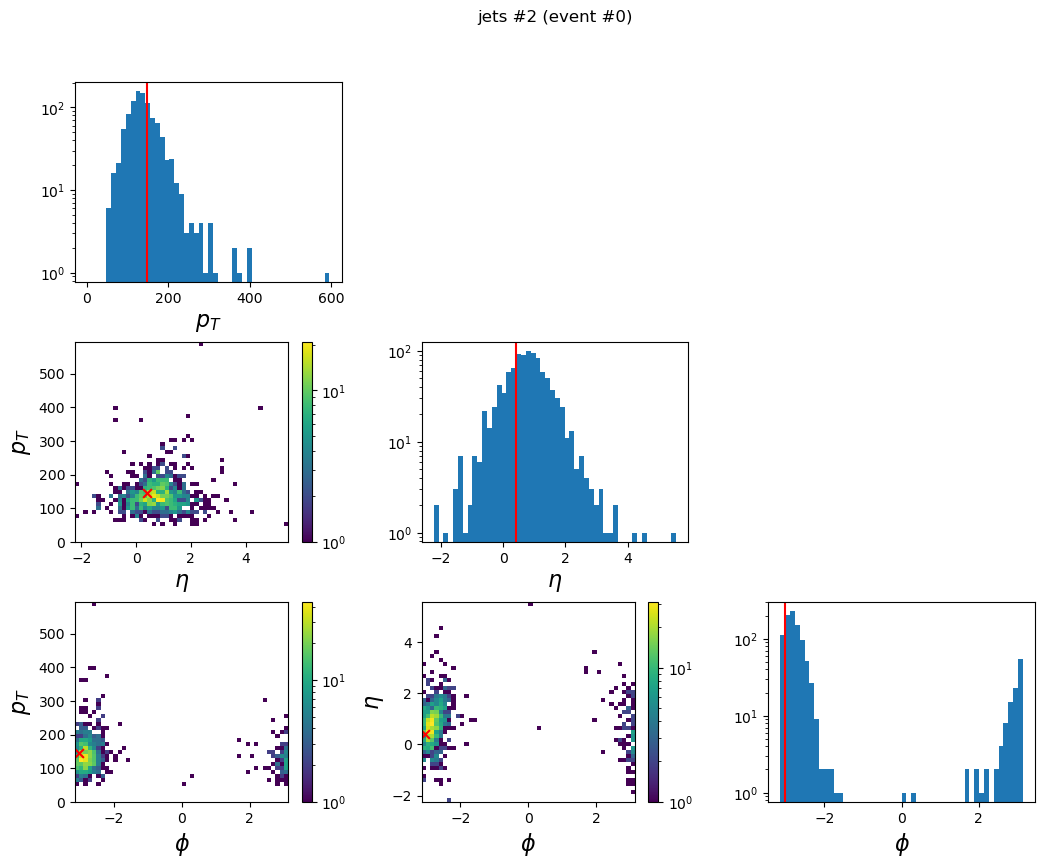

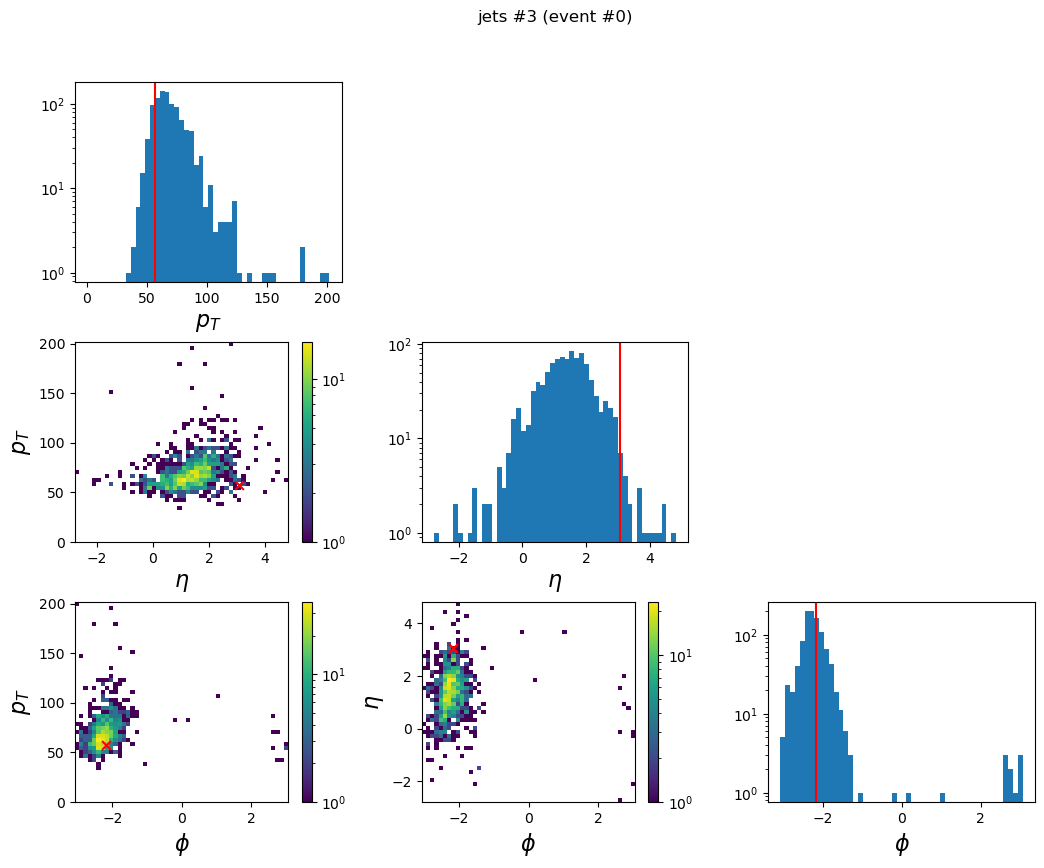

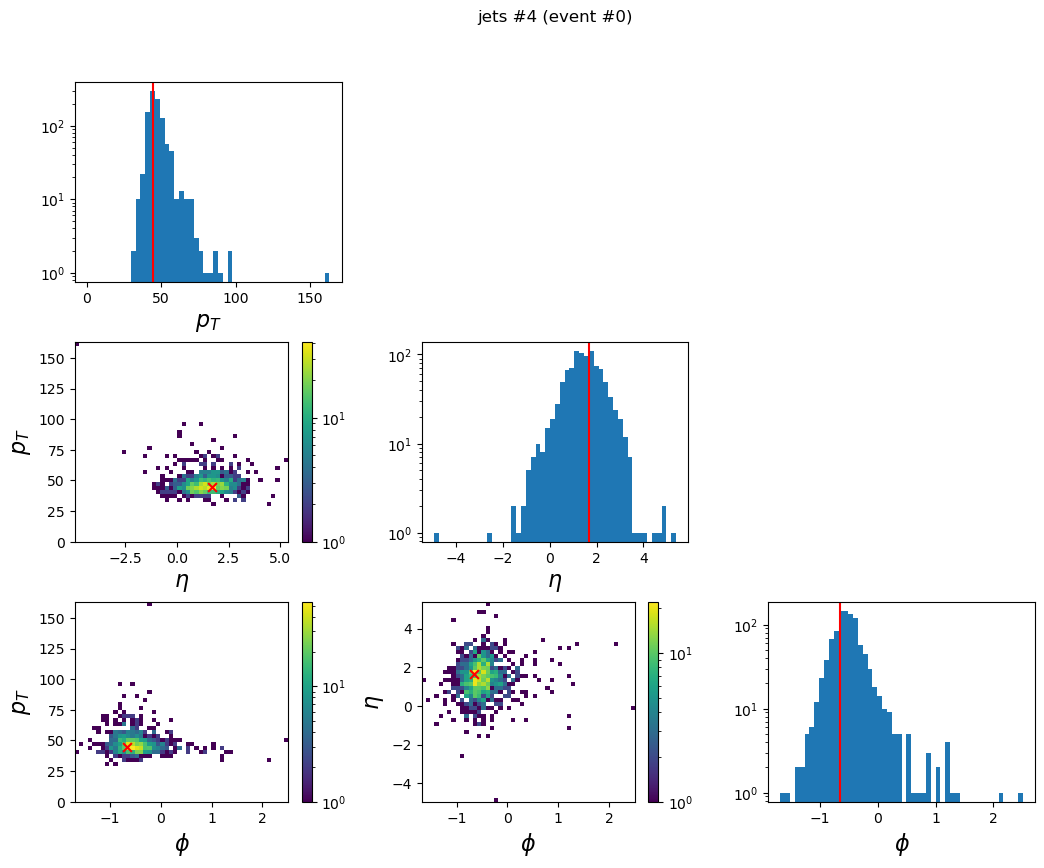

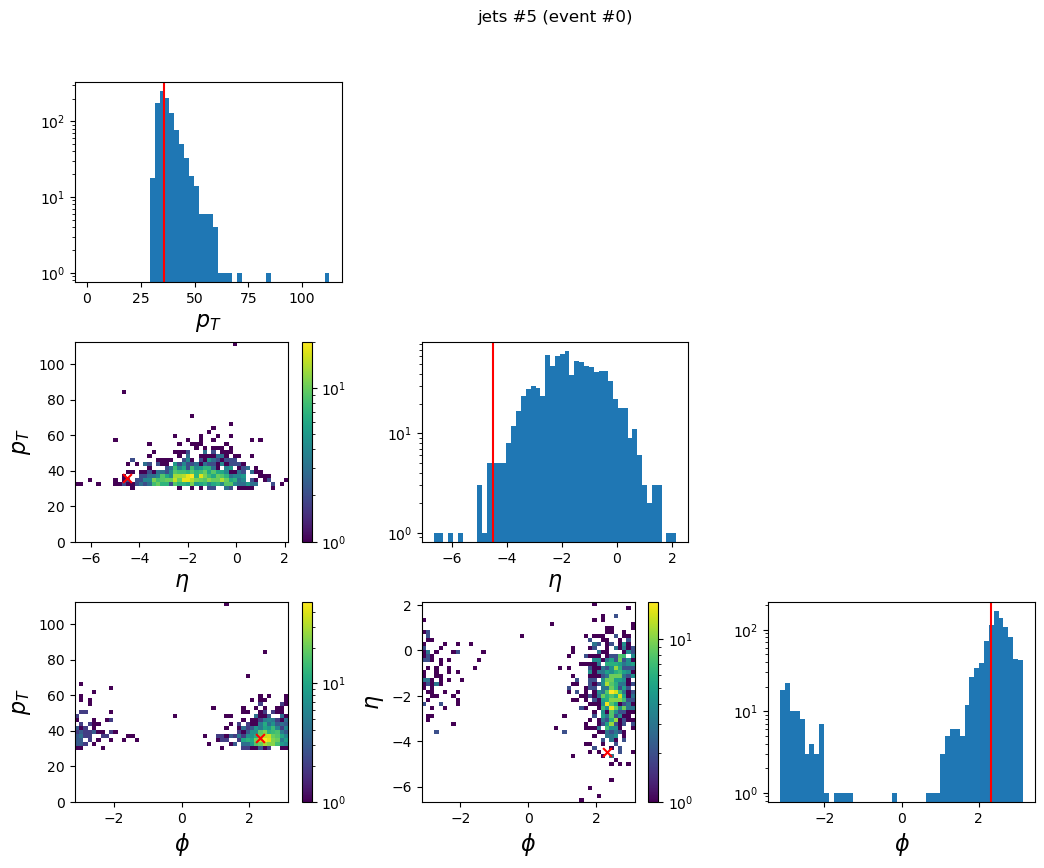

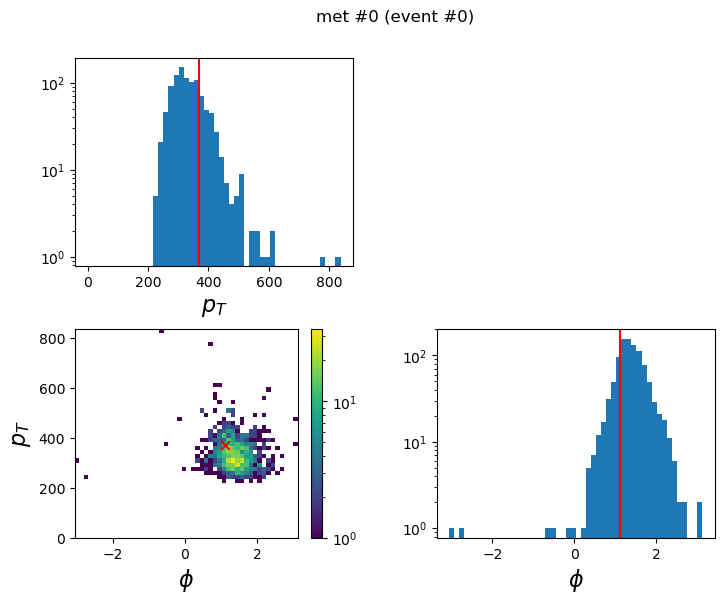

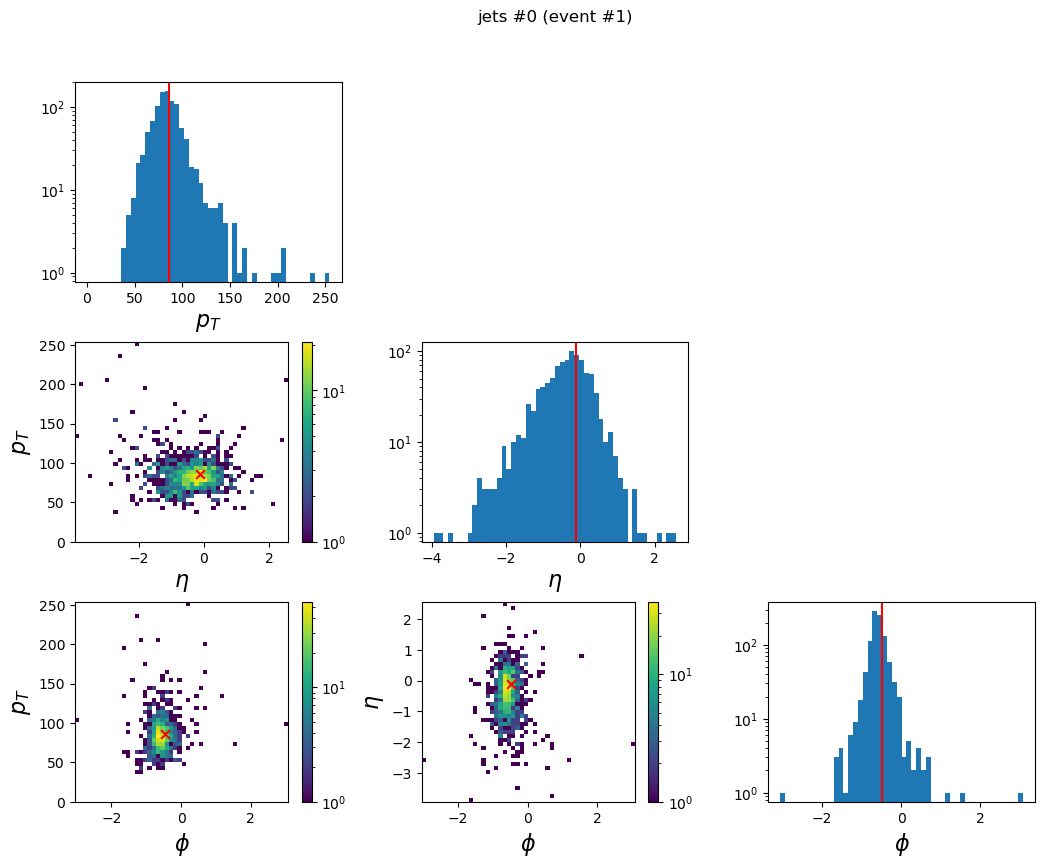

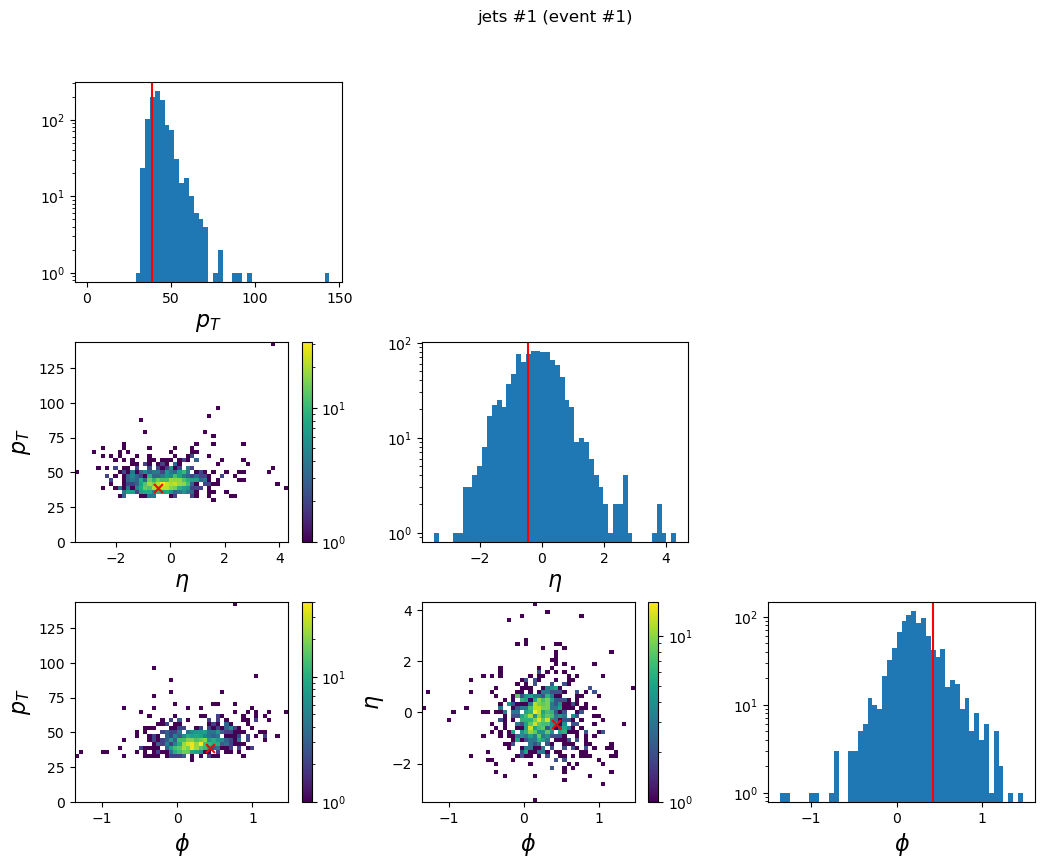

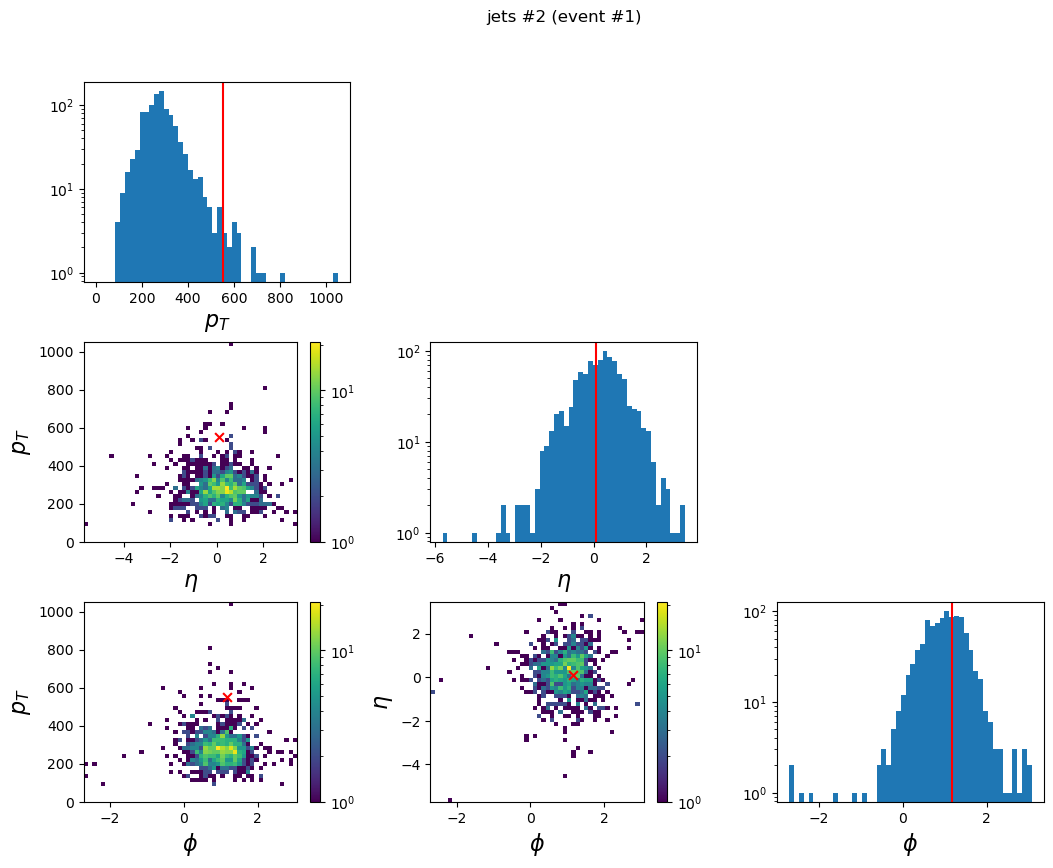

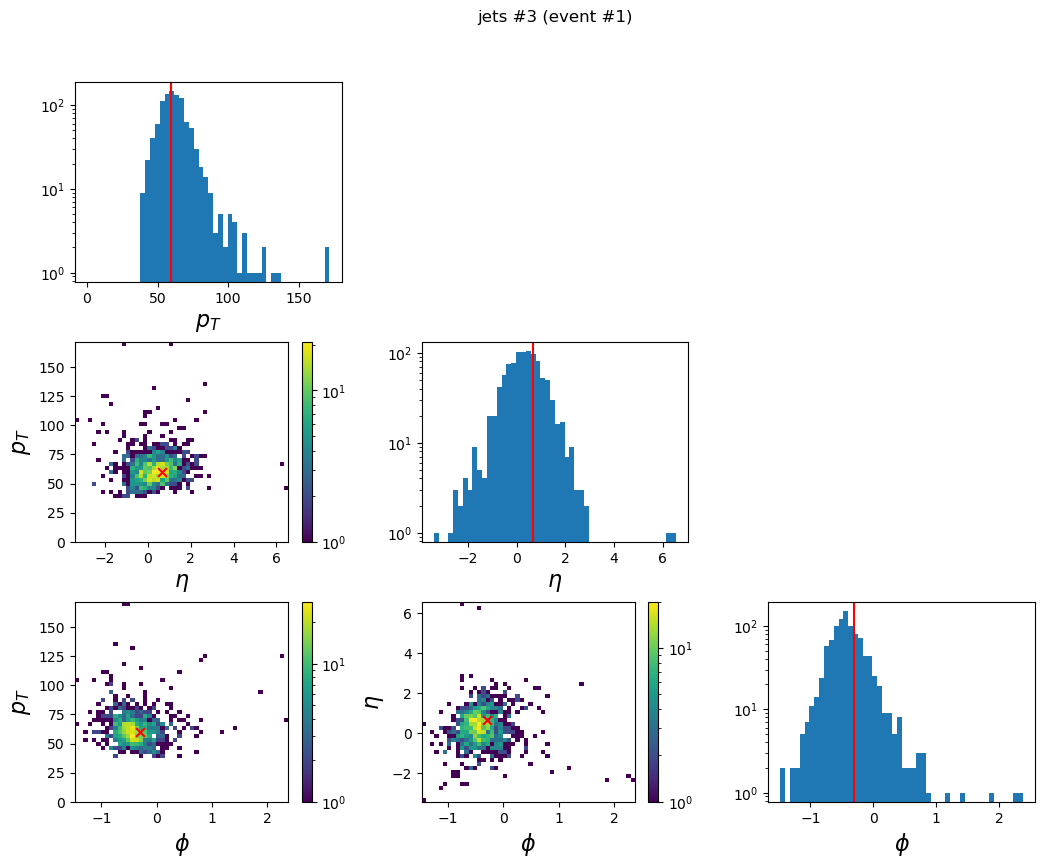

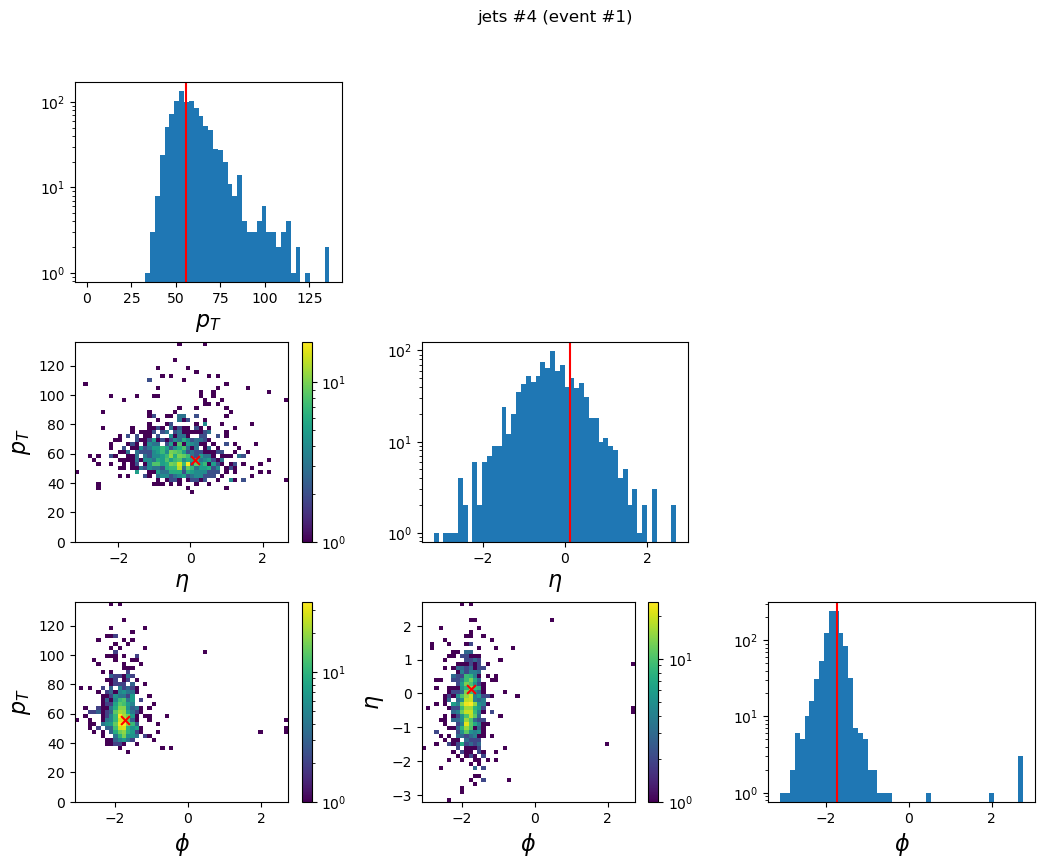

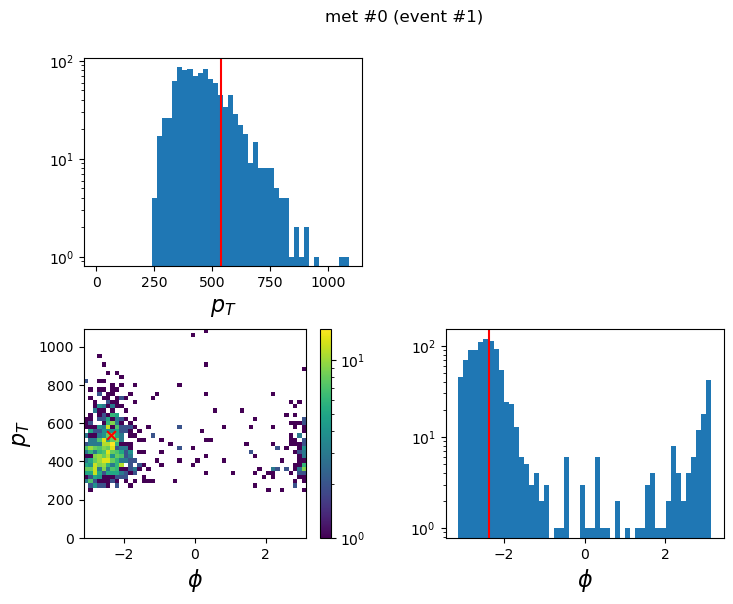

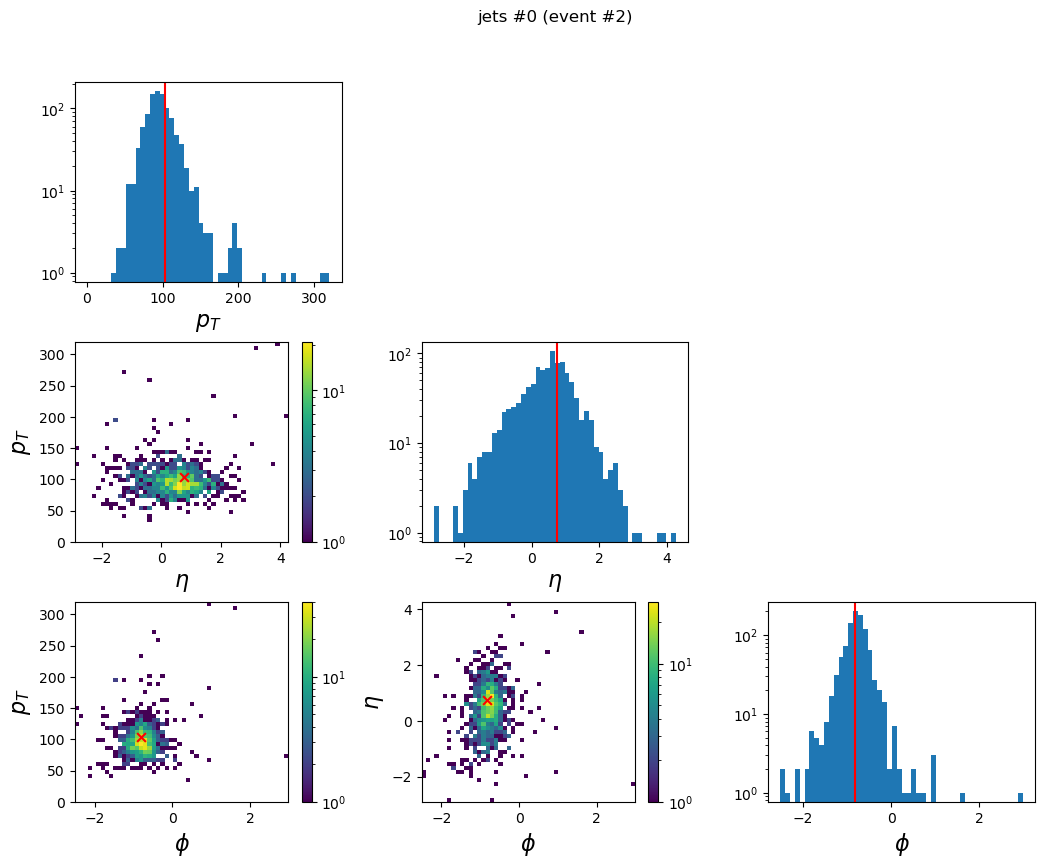

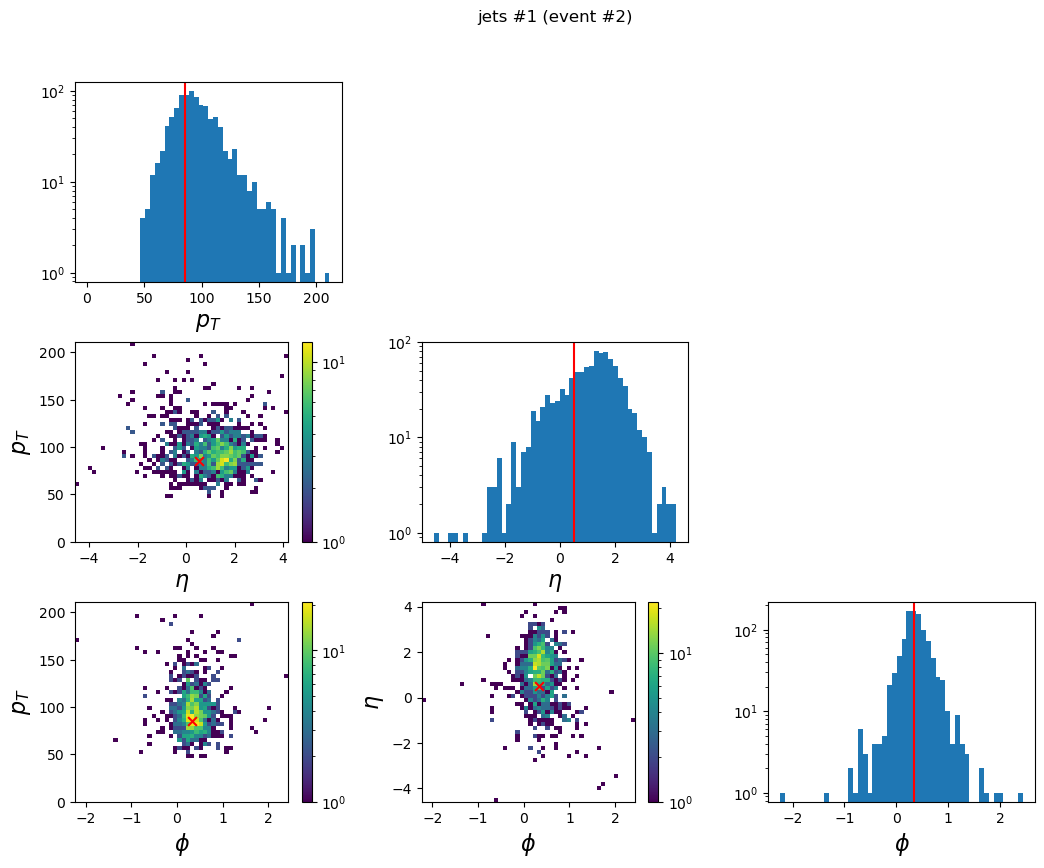

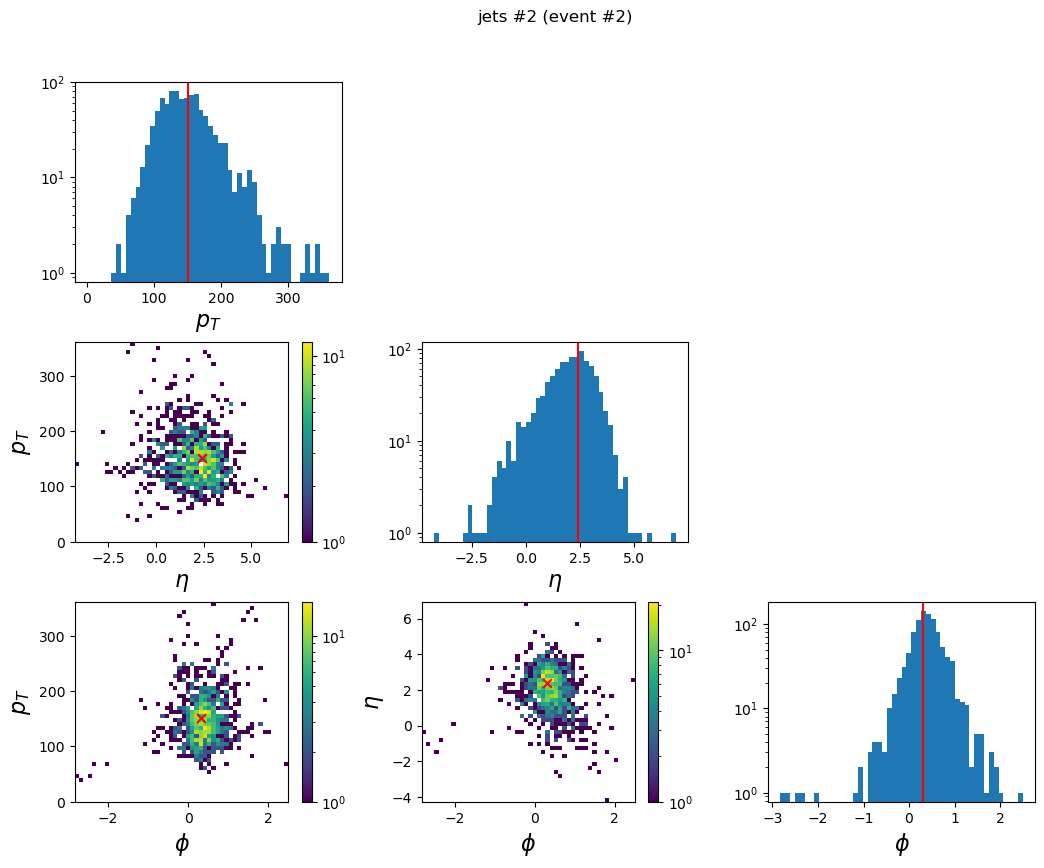

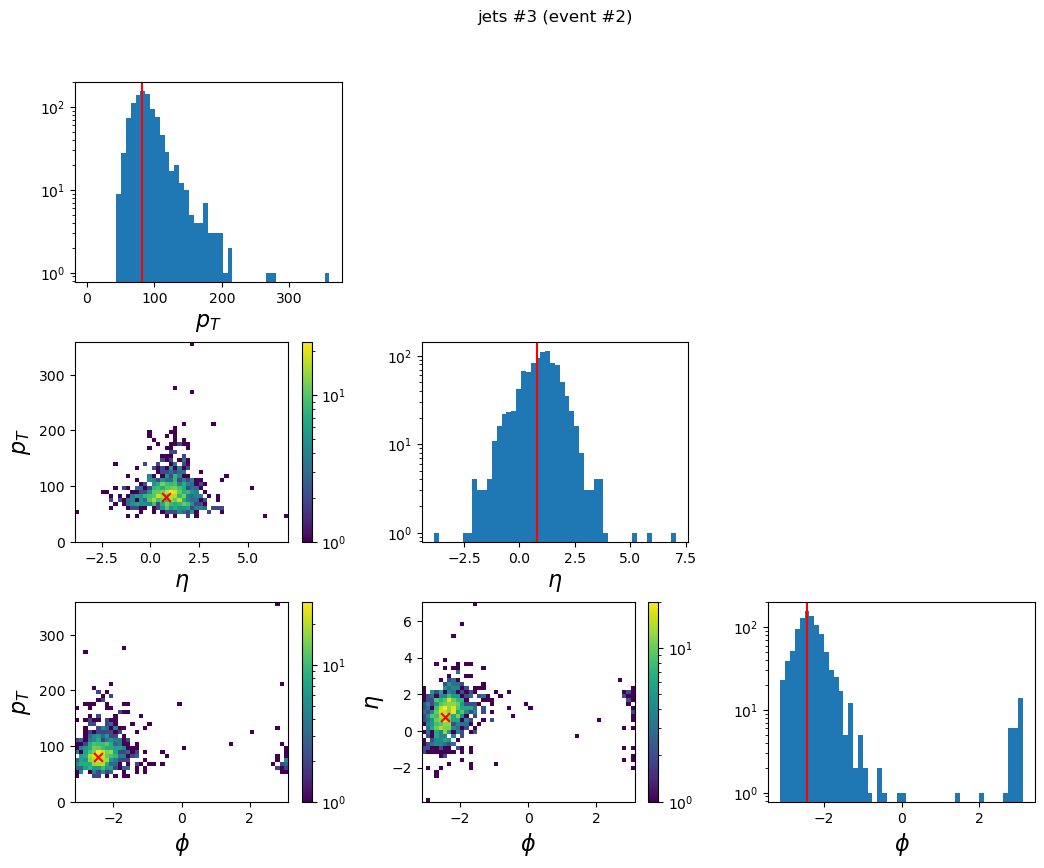

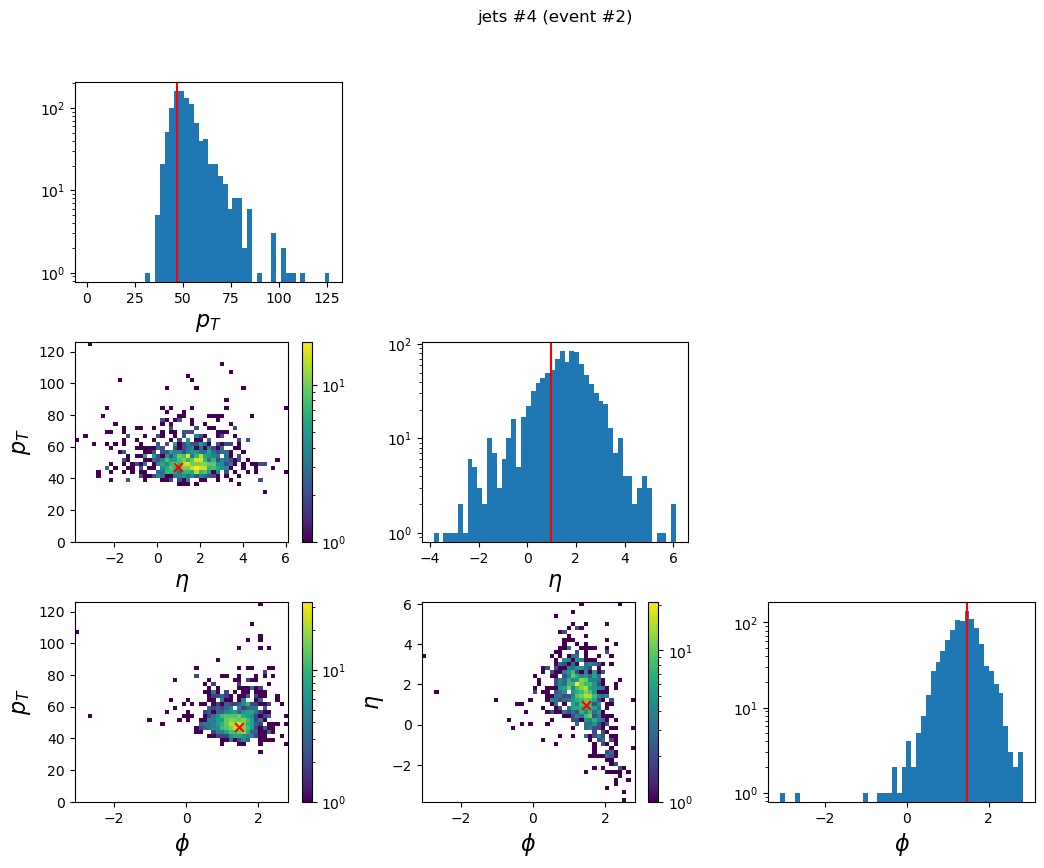

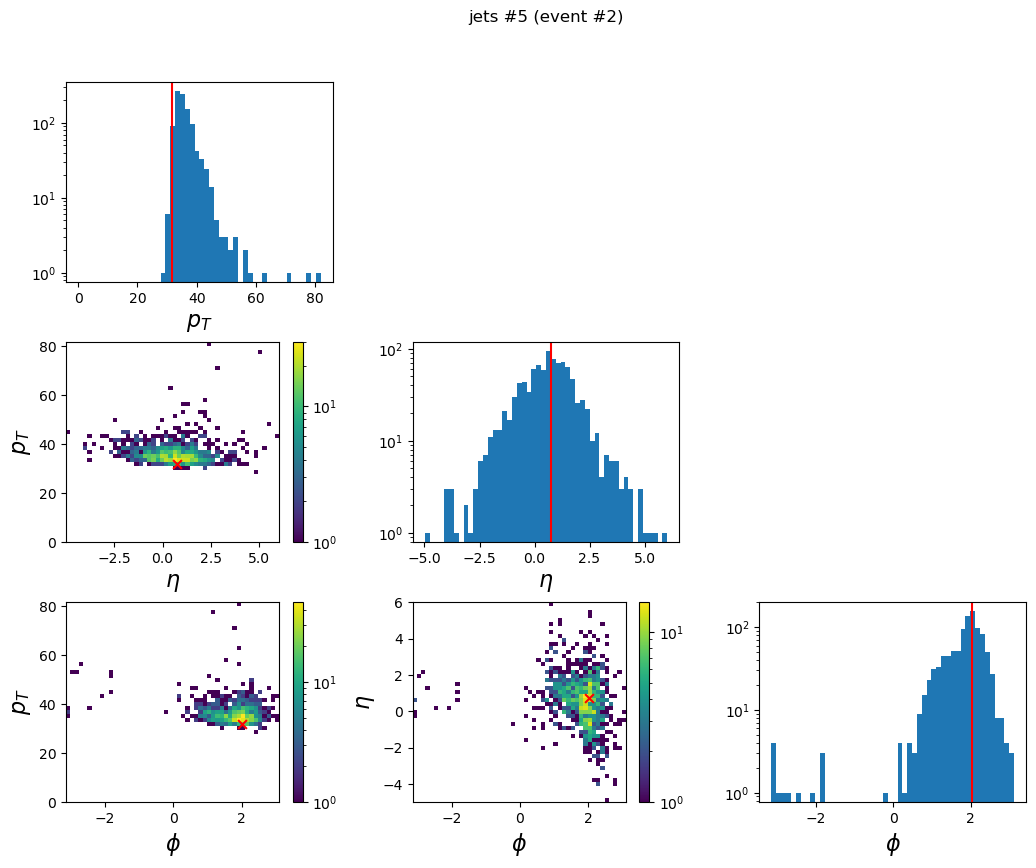

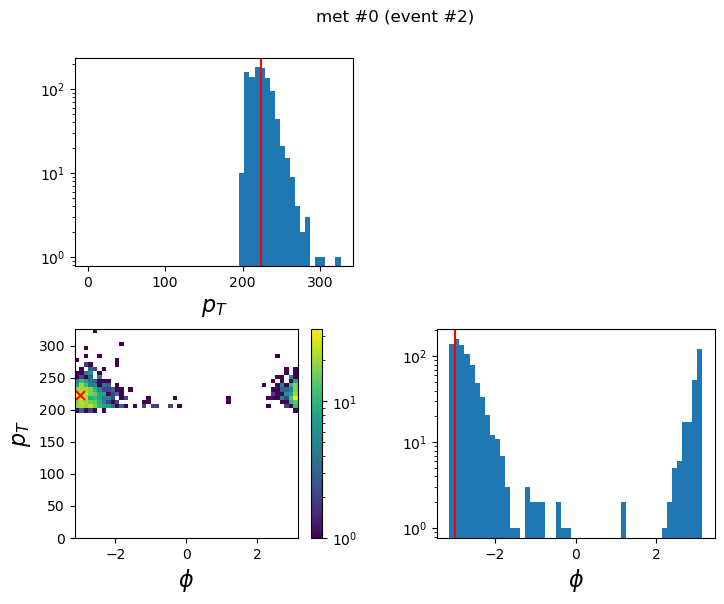

Predict:   0%|          | 0/1 [00:54<?, ?it/s]


KeyboardInterrupt: 

In [26]:
figures = sampling.make_sampling_plots(model,show=True)
figs = bias.make_bias_plots(model,show=True)